<a href="https://colab.research.google.com/github/PaudelSiddhanta/Rectangular_EIT/blob/main/rect_non_lin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.optimize import root, minimize
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
from matplotlib.colors import Normalize
from rect_grid import Node, GridStructure
from rect_NN_helper import generate_dtn_data

/content/solve_linear.py:27: SyntaxWarning: invalid escape sequence '\m'
  a function outputing the Gaussian transformation matrix $\mathbf{M}_k$ associated to a series of coefficients $\mathbf{c}^{(k)}$.


In [2]:
gr1 = GridStructure(5)

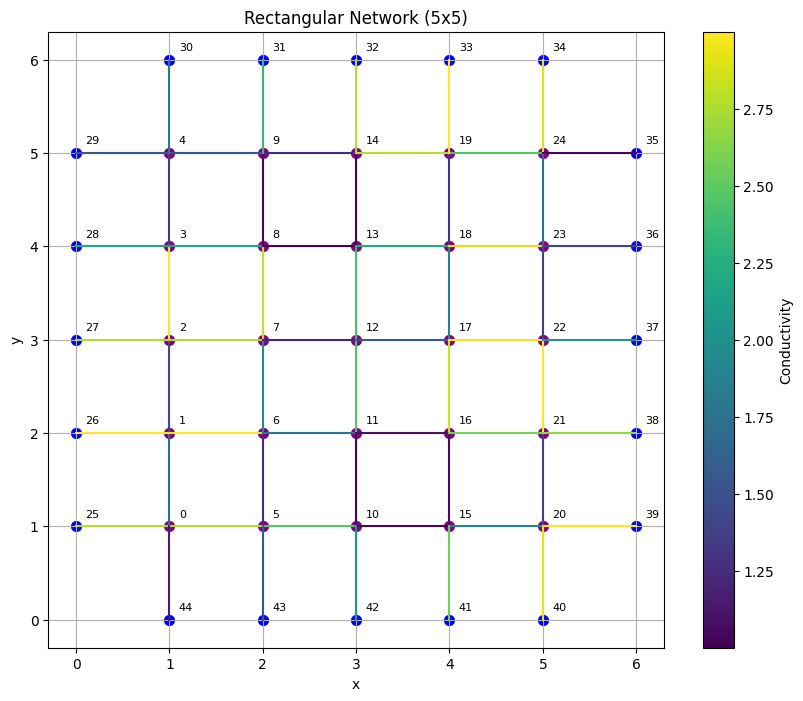

In [3]:
gr1.visualize_network()

In [4]:
# gr1.interior_index

In [5]:
# interior_map = {idx: i for i, idx in enumerate(gr1.interior_index)}
# interior_map

The code below is just an outline for the non linear case. there are some ideas and structures we ought to follow to first solve the forward problem and then proceed to solve the inverse problem.

In [6]:
import numpy as np
from scipy.optimize import root, minimize
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

# Assumes rect_grid.py is available with GridStructure class

class NonlinearEITSolver(GridStructure):
    def __init__(self, n, alpha=0.1):
        super().__init__(n)
        self.alpha = np.full(self.internal_node_count, alpha)
        self.true_conductivities = None
        self.true_neumann = None

    def nonlinear_forward_problem(self, dirichlet_data):
        if set(dirichlet_data.keys()) != set(self.boundary_index):
            raise ValueError("Dirichlet data must specify all boundary nodes.")

        interior_map = {idx: i for i, idx in enumerate(self.interior_index)}

        def F(u):
            F_u = np.zeros(self.internal_node_count)
            for matrix_idx, node_idx in enumerate(self.interior_index):
                node = self.get_node_by_index(node_idx)
                s = 0.0
                for neighbor_idx in node.neighbors:
                    edge = tuple(sorted([node_idx, neighbor_idx]))
                    gamma = self.conductivities[edge]
                    if neighbor_idx in self.boundary_index:
                        s += gamma * (dirichlet_data[neighbor_idx] - u[matrix_idx])
                    else:
                        s += gamma * (u[interior_map[neighbor_idx]] - u[matrix_idx])
                F_u[matrix_idx] = s - self.alpha[matrix_idx] * u[matrix_idx]**3
            return F_u

        def jacobian(u):
            J = np.zeros((self.internal_node_count, self.internal_node_count))  # Dense array
            for matrix_idx, node_idx in enumerate(self.interior_index):
                node = self.get_node_by_index(node_idx)
                sum_gamma = 0.0
                for neighbor_idx in node.neighbors:
                    edge = tuple(sorted([node_idx, neighbor_idx]))
                    gamma = self.conductivities[edge]
                    sum_gamma += gamma
                    if neighbor_idx in self.interior_index:
                        J[matrix_idx, interior_map[neighbor_idx]] = gamma
                J[matrix_idx, matrix_idx] = -sum_gamma - 3 * self.alpha[matrix_idx] * u[matrix_idx]**2
            return J

        u0 = np.zeros(self.internal_node_count)
        sol = root(F, u0, jac=jacobian, method='hybr')  # Removed options={'disp': False}
        if not sol.success:
            raise RuntimeError("Nonlinear solver failed: " + sol.message)
        interior_potentials = sol.x

        potentials = np.zeros(self.node_count)
        for matrix_idx, node_idx in enumerate(self.interior_index):
            potentials[node_idx] = interior_potentials[matrix_idx]
        for idx in self.boundary_index:
            potentials[idx] = dirichlet_data[idx]

        neumann_data = {}
        for idx in self.boundary_index:
            node = self.get_node_by_index(idx)
            neighbor_idx = node.neighbors[0]
            edge = tuple(sorted([idx, neighbor_idx]))
            gamma = self.conductivities[edge]
            neumann_data[idx] = gamma * (potentials[idx] - potentials[neighbor_idx])

        return potentials, neumann_data

    def generate_dtn_data(self, batch_size):
        batch_size = min(batch_size, 4 * self.n)
        dirichlet = np.zeros((batch_size, 4 * self.n))
        neumann = np.zeros((batch_size, 4 * self.n))

        for k in range(batch_size):
            dirichlet_data = {idx: 1.0 if idx == self.boundary_index[k] else 0.0
                              for idx in self.boundary_index}
            potentials, neumann_data = self.nonlinear_forward_problem(dirichlet_data)
            dirichlet[k, k] = 1.0
            for j, idx in enumerate(self.boundary_index):
                neumann[k, j] = neumann_data[idx]

        data = np.concatenate((dirichlet, neumann), axis=1)
        return data

    def compute_net_current(self, potentials):
        net_current = {}
        for idx in self.interior_index + self.boundary_index:
            node = self.get_node_by_index(idx)
            s = 0.0
            for neighbor_idx in node.neighbors:
                edge = tuple(sorted([idx, neighbor_idx]))
                gamma = self.conductivities[edge]
                s += gamma * (potentials[idx] - potentials[neighbor_idx])
            if idx in self.interior_index:
                s -= self.alpha[self.interior_index.index(idx)] * potentials[idx]**3
            net_current[idx] = s
        return net_current

    def set_true_data(self, batch_size):
        self.true_conductivities = self.conductivities.copy()
        self.true_neumann = np.zeros((batch_size, 4 * self.n))
        for k in range(batch_size):
            dirichlet_data = {idx: 1.0 if idx == self.boundary_index[k] else 0.0
                              for idx in self.boundary_index}
            _, neumann_data = self.nonlinear_forward_problem(dirichlet_data)
            for j, idx in enumerate(self.boundary_index):
                self.true_neumann[k, j] = neumann_data[idx]

    def inverse_problem(self, dtn_data, reg_alpha=0.8):
        m = dtn_data.shape[0]
        if self.true_neumann is None:
            raise ValueError("Precompute true Neumann with set_true_data()")

        def loss(gamma_tilde):
            for i, edge in enumerate(self.edges):
                self.conductivities[edge] = max(gamma_tilde[i], 0.01)
            total_loss = 0.0
            for k in range(m):
                dirichlet_data = {idx: dtn_data[k, j] for j, idx in enumerate(self.boundary_index)}
                potentials, _ = self.nonlinear_forward_problem(dirichlet_data)
                net_current = self.compute_net_current(potentials)
                y_boundary = np.array([net_current[idx] - self.true_neumann[k, j] for j, idx in enumerate(self.boundary_index)])
                y_interior = np.array([net_current[idx] for idx in self.interior_index])
                total_loss += np.sum(y_boundary**2) + reg_alpha * np.sum(y_interior**2)
            return total_loss / (2 * m)

        gamma0 = np.ones(self.edge_count) * 0.5
        res = minimize(loss, gamma0, method='L-BFGS-B', bounds=[(0.01, None)] * self.edge_count)
        if not res.success:
            print("Warning: Minimization may not have converged:", res.message)
        recovered_gamma = {edge: max(res.x[i], 0.01) for i, edge in enumerate(self.edges)}
        return recovered_gamma, res.fun

    def visualize_conductivities(self, recovered_gamma):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Collect all conductivity values for shared scaling
        true_vals = np.array([self.true_conductivities[edge] for edge in self.edges])
        rec_vals = np.array([recovered_gamma.get(edge, 0.0) for edge in self.edges])
        all_vals = np.concatenate([true_vals, rec_vals])
        norm = Normalize(vmin=min(all_vals), vmax=max(all_vals))

        # Plot original conductivities
        x = [self.get_node_by_index(idx).x for idx in range(self.node_count)]
        y = [self.get_node_by_index(idx).y for idx in range(self.node_count)]
        for idx in range(self.node_count):
            node = self.get_node_by_index(idx)
            color = 'blue' if node.is_boundary else 'purple'
            ax1.scatter(node.x, node.y, c=[color], s=50)
            ax1.text(node.x + 0.2, node.y + 0.2, f"{idx}", fontsize=12)
        for edge in self.edges:
            node1, node2 = self.get_node_by_index(edge[0]), self.get_node_by_index(edge[1])
            color = self.true_conductivities[edge]
            ax1.plot([node1.x, node2.x], [node1.y, node2.y], color=viridis(norm(color)), lw=1.5)
        ax1.set_title("Original Conductivities")
        ax1.set_aspect('equal')
        ax1.set_xticks(range(self.n + 2))  # Dynamic ticks for any n
        ax1.set_yticks(range(self.n + 2))
        ax1.grid(True)

        # Plot recovered conductivities
        for idx in range(self.node_count):
            node = self.get_node_by_index(idx)
            color = 'blue' if node.is_boundary else 'purple'
            ax2.scatter(node.x, node.y, c=[color], s=50)
            ax2.text(node.x + 0.2, node.y + 0.2, f"{idx}", fontsize=12)
        for edge in self.edges:
            node1, node2 = self.get_node_by_index(edge[0]), self.get_node_by_index(edge[1])
            color = recovered_gamma.get(edge, 0.0)
            ax2.plot([node1.x, node2.x], [node1.y, node2.y], color=viridis(norm(color)), lw=1.5)
        ax2.set_title("Recovered Conductivities")
        ax2.set_aspect('equal')
        ax2.set_xticks(range(self.n + 2))  # Dynamic ticks for any n
        ax2.set_yticks(range(self.n + 2))
        ax2.grid(True)

        plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=viridis), ax=[ax1, ax2], label='Conductivity')
        plt.show()

Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.137771        2.152150       
(0,3)      2.975587        2.966809       
(0,9)      2.975587        2.975129       
(0,20)     1.145108        1.145188       
(1,2)      1.340625        1.345568       
(1,4)      2.605040        2.650292       
(1,10)     2.605040        2.596571       
(2,5)      1.527099        1.524821       
(2,11)     1.527099        1.527300       
(2,12)     2.964029        2.963448       
(3,4)      2.631639        2.567124       
(3,6)      2.014436        2.011083       
(3,19)     1.538321        1.540200       
(4,5)      1.046260        1.050204       
(4,7)      1.096460        1.098378       
(5,8)      1.234876        1.233345       
(5,13)     2.962038        2.962941       
(6,7)      2.942194        2.949693       
(6,17)     1.018480        1.018470       
(6,18)     2.065520        2.065318       
(7,8)      1.028686      

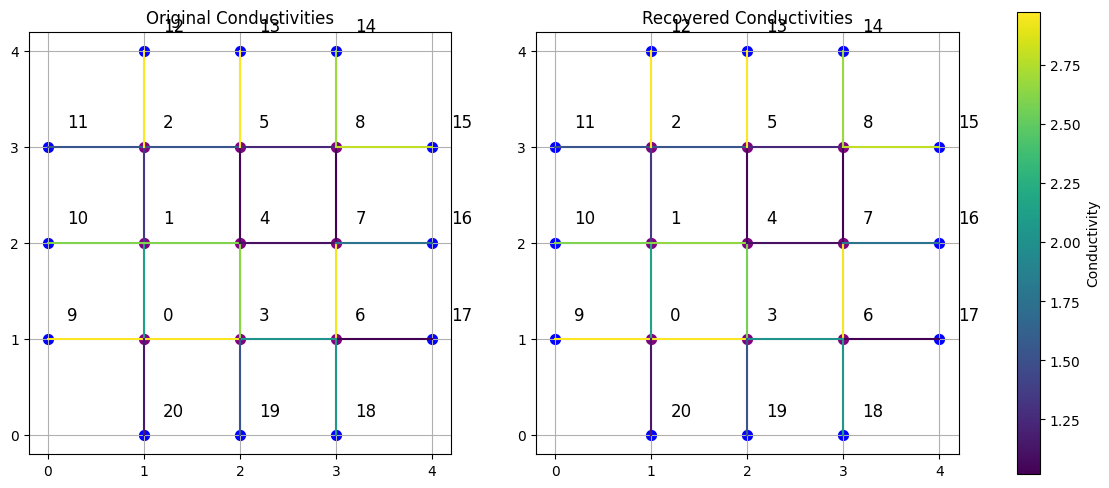

In [7]:
n = 3
solver = NonlinearEITSolver(n, alpha=0.05)
batch_size = 4*n
solver.set_true_data(batch_size)
dtn_data = solver.generate_dtn_data(batch_size)
recovered_gamma, loss_value = solver.inverse_problem(dtn_data, reg_alpha=0.8)

# Tabular display of conductivities
print("Conductivity Comparison Table:")
print(f"{'Edge':<10} {'True Gamma':<15} {'Recovered Gamma':<15}")
print("-" * 40)
for edge, true_value in solver.true_conductivities.items():
    recovered_value = recovered_gamma.get(edge, 0.0)  # Default to 0 if not found
    edge_str = f"({edge[0]},{edge[1]})"
    print(f"{edge_str:<10} {true_value:<15.6f} {recovered_value:<15.6f}")
print(f"Loss at Minimum: {loss_value}")
# Visualize conductivities
solver.visualize_conductivities(recovered_gamma)

In [8]:

def run_demo(n, i,alpha=0.05):
  solver = NonlinearEITSolver(n, alpha=0.05)
  batch_size = i
  solver.set_true_data(batch_size)
  dtn_data = solver.generate_dtn_data(batch_size)
  recovered_gamma, loss_value = solver.inverse_problem(dtn_data, reg_alpha=0.8)

  # Tabular display of conductivities
  print("Conductivity Comparison Table:")
  print(f"{'Edge':<10} {'True Gamma':<15} {'Recovered Gamma':<15}")
  print("-" * 40)
  for edge, true_value in solver.true_conductivities.items():
    recovered_value = recovered_gamma.get(edge, 0.0)  # Default to 0 if not found
    edge_str = f"({edge[0]},{edge[1]})"
    print(f"{edge_str:<10} {true_value:<15.6f} {recovered_value:<15.6f}")
  print(f"Loss at Minimum: {loss_value}")
  # Visualize conductivities
  solver.visualize_conductivities(recovered_gamma)


In [11]:
#running for n = 2:

def run_demo_batch(n1):

  for i in range(4*n1,1,-1):
    print(".........................................")
    print()
    print()
    print("for n = ",n1)
    print("the batch size used for this training is ", i)
    # print("")
    run_demo(n1,i)
    print()
    print()
    print(".........................................")
    print()
    print()

.........................................


for n =  2
the batch size used for this training is  8
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.340625        1.341419       
(0,2)      2.939448        2.940729       
(0,4)      2.939448        2.938269       
(0,11)     1.145108        1.145359       
(1,3)      1.527099        1.528941       
(1,5)      1.527099        1.527303       
(1,6)      1.978146        1.977858       
(2,3)      1.046260        1.045298       
(2,9)      1.471560        1.471487       
(2,10)     1.538321        1.538250       
(3,7)      1.462634        1.462551       
(3,8)      1.234876        1.234816       
Loss at Minimum: 5.661128740040796e-06


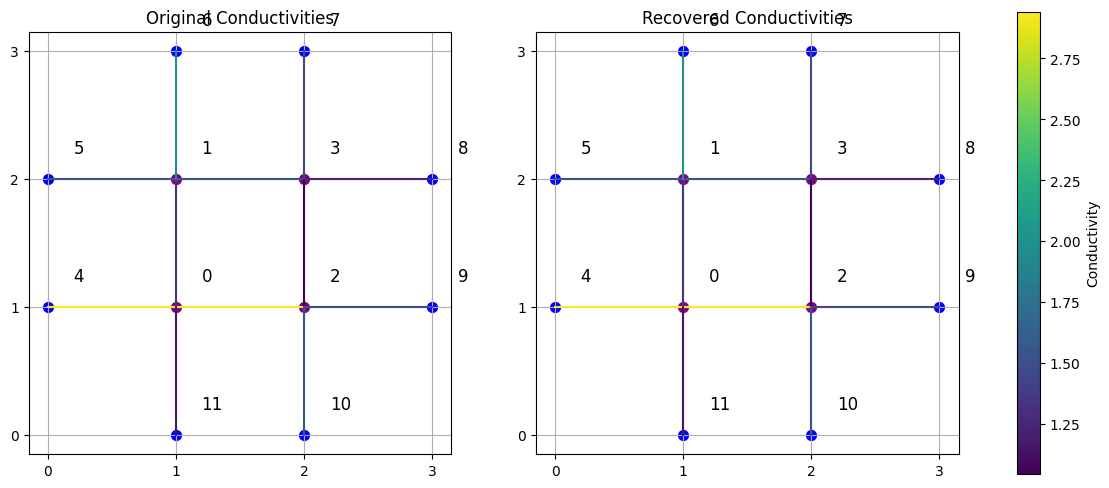



.........................................


.........................................


for n =  2
the batch size used for this training is  7
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.340625        1.341684       
(0,2)      2.939448        2.943795       
(0,4)      2.939448        2.937996       
(0,11)     1.145108        1.145706       
(1,3)      1.527099        1.526230       
(1,5)      1.527099        1.527200       
(1,6)      1.978146        1.978018       
(2,3)      1.046260        1.046417       
(2,9)      1.471560        1.471468       
(2,10)     1.538321        1.538228       
(3,7)      1.462634        1.462688       
(3,8)      1.234876        1.234990       
Loss at Minimum: 6.4427738137937725e-06


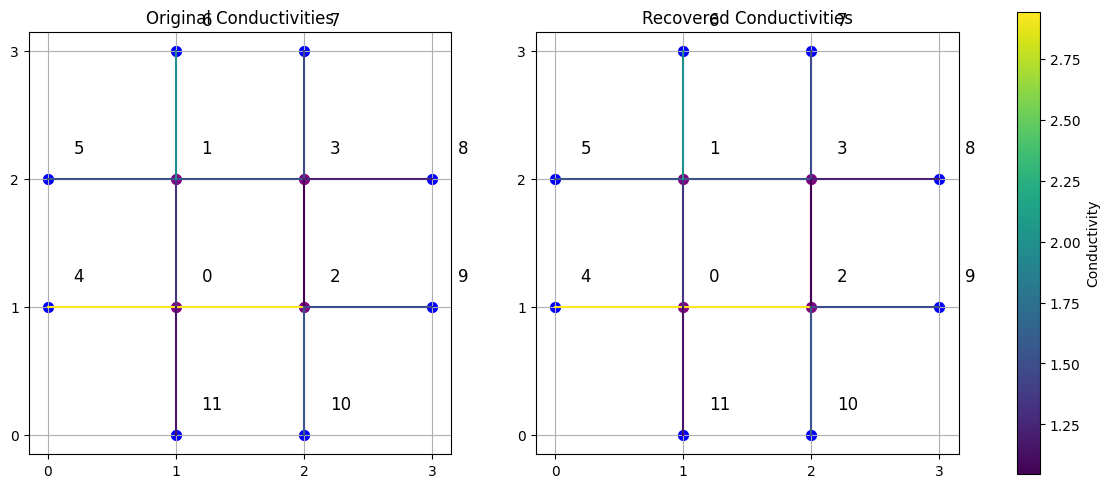



.........................................


.........................................


for n =  2
the batch size used for this training is  6
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.340625        1.342211       
(0,2)      2.939448        2.944699       
(0,4)      2.939448        2.937070       
(0,11)     1.145108        1.146339       
(1,3)      1.527099        1.526821       
(1,5)      1.527099        1.527153       
(1,6)      1.978146        1.978004       
(2,3)      1.046260        1.045920       
(2,9)      1.471560        1.471469       
(2,10)     1.538321        1.538547       
(3,7)      1.462634        1.462633       
(3,8)      1.234876        1.234993       
Loss at Minimum: 7.2353413415809536e-06


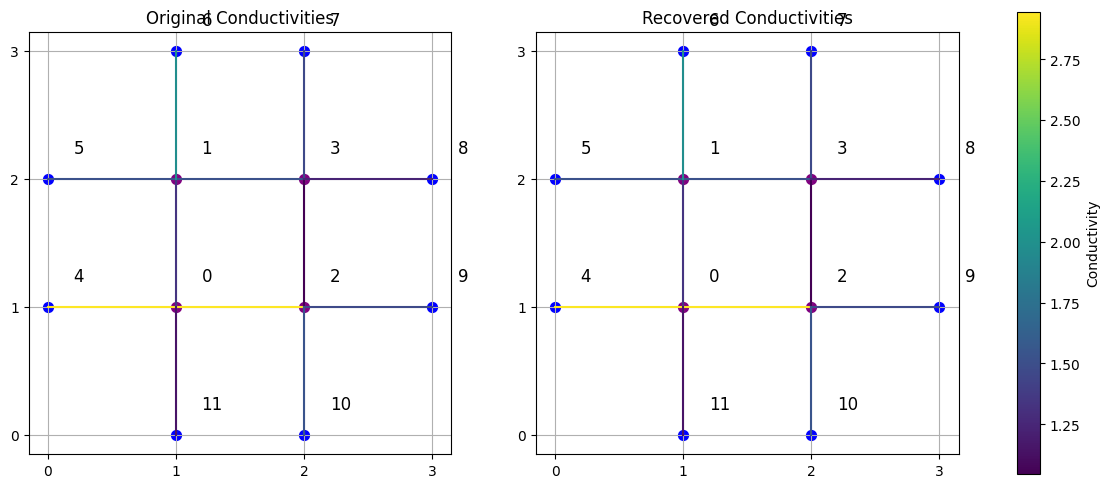



.........................................


.........................................


for n =  2
the batch size used for this training is  5
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.340625        1.342296       
(0,2)      2.939448        2.952441       
(0,4)      2.939448        2.935909       
(0,11)     1.145108        1.146919       
(1,3)      1.527099        1.526259       
(1,5)      1.527099        1.527138       
(1,6)      1.978146        1.977993       
(2,3)      1.046260        1.046289       
(2,9)      1.471560        1.469527       
(2,10)     1.538321        1.536522       
(3,7)      1.462634        1.462771       
(3,8)      1.234876        1.234812       
Loss at Minimum: 8.420741239364937e-06


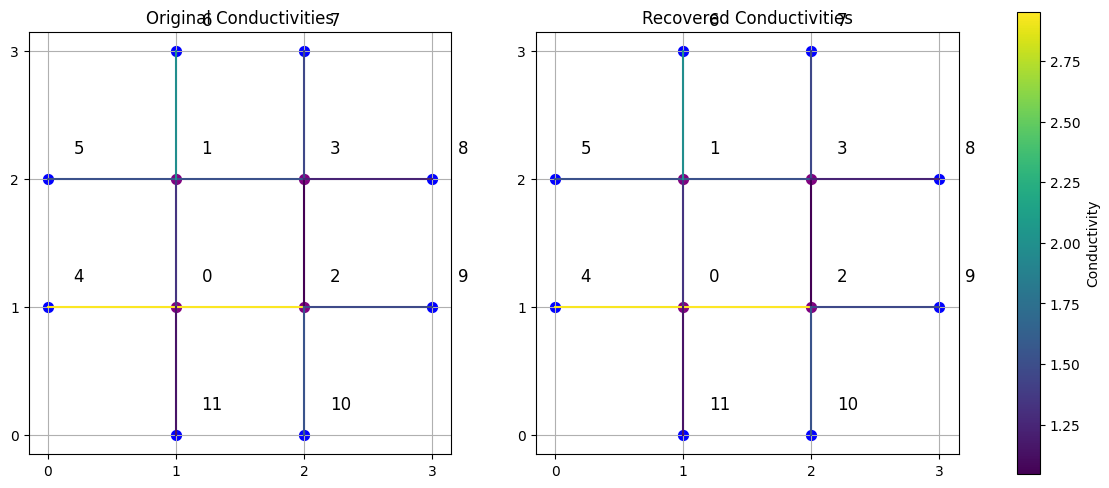



.........................................


.........................................


for n =  2
the batch size used for this training is  4
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.340625        1.342944       
(0,2)      2.939448        2.957299       
(0,4)      2.939448        2.934343       
(0,11)     1.145108        1.147520       
(1,3)      1.527099        1.527135       
(1,5)      1.527099        1.527161       
(1,6)      1.978146        1.977975       
(2,3)      1.046260        1.047402       
(2,9)      1.471560        1.469237       
(2,10)     1.538321        1.535844       
(3,7)      1.462634        1.462502       
(3,8)      1.234876        1.235074       
Loss at Minimum: 1.0172206392170255e-05


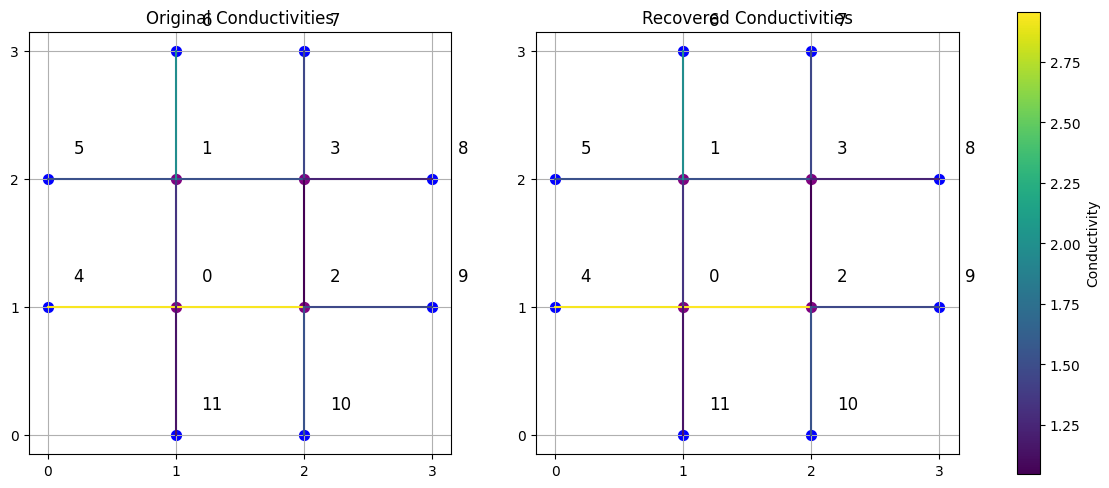



.........................................


.........................................


for n =  2
the batch size used for this training is  3
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.340625        1.351049       
(0,2)      2.939448        2.940766       
(0,4)      2.939448        2.928995       
(0,11)     1.145108        1.150208       
(1,3)      1.527099        1.504401       
(1,5)      1.527099        1.527129       
(1,6)      1.978146        1.977992       
(2,3)      1.046260        1.041956       
(2,9)      1.471560        1.484783       
(2,10)     1.538321        1.551992       
(3,7)      1.462634        1.491902       
(3,8)      1.234876        1.259325       
Loss at Minimum: 1.2239635888054595e-05


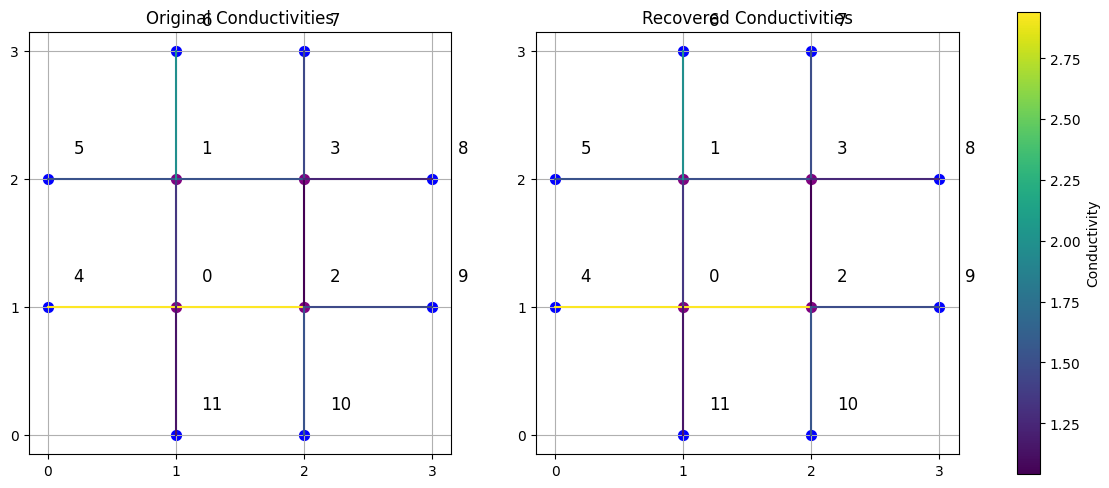



.........................................


.........................................


for n =  2
the batch size used for this training is  2
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.340625        1.366145       
(0,2)      2.939448        2.975860       
(0,4)      2.939448        2.912809       
(0,11)     1.145108        1.158546       
(1,3)      1.527099        1.488370       
(1,5)      1.527099        1.525816       
(1,6)      1.978146        1.982721       
(2,3)      1.046260        1.031053       
(2,9)      1.471560        1.485380       
(2,10)     1.538321        1.552759       
(3,7)      1.462634        1.515235       
(3,8)      1.234876        1.277744       
Loss at Minimum: 1.4260133381547193e-05


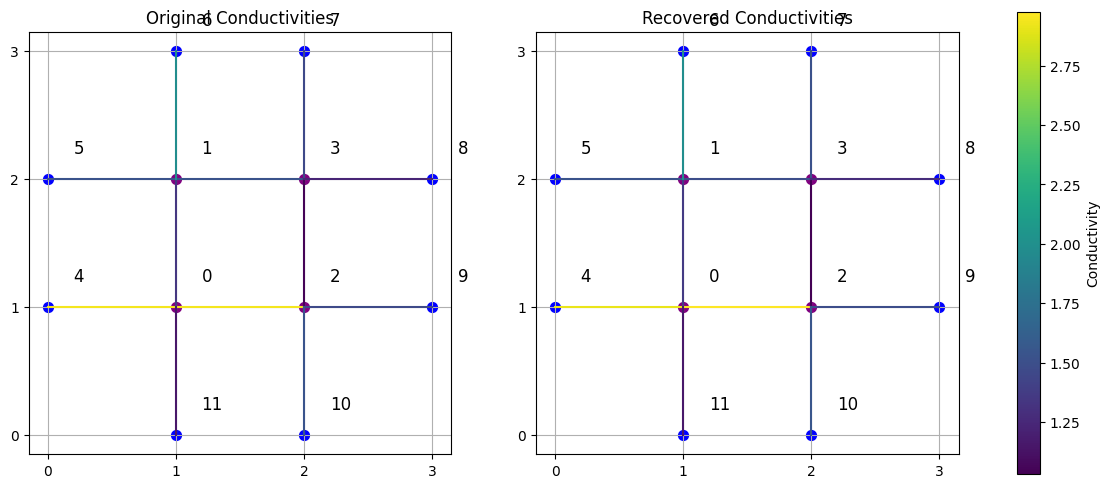



.........................................




In [12]:

run_demo_batch(2)

.........................................


for n =  3
the batch size used for this training is  12
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.137771        2.152150       
(0,3)      2.975587        2.966809       
(0,9)      2.975587        2.975129       
(0,20)     1.145108        1.145188       
(1,2)      1.340625        1.345568       
(1,4)      2.605040        2.650292       
(1,10)     2.605040        2.596571       
(2,5)      1.527099        1.524821       
(2,11)     1.527099        1.527300       
(2,12)     2.964029        2.963448       
(3,4)      2.631639        2.567124       
(3,6)      2.014436        2.011083       
(3,19)     1.538321        1.540200       
(4,5)      1.046260        1.050204       
(4,7)      1.096460        1.098378       
(5,8)      1.234876        1.233345       
(5,13)     2.962038        2.962941       
(6,7)      2.942194        2.949693       
(6,17)     

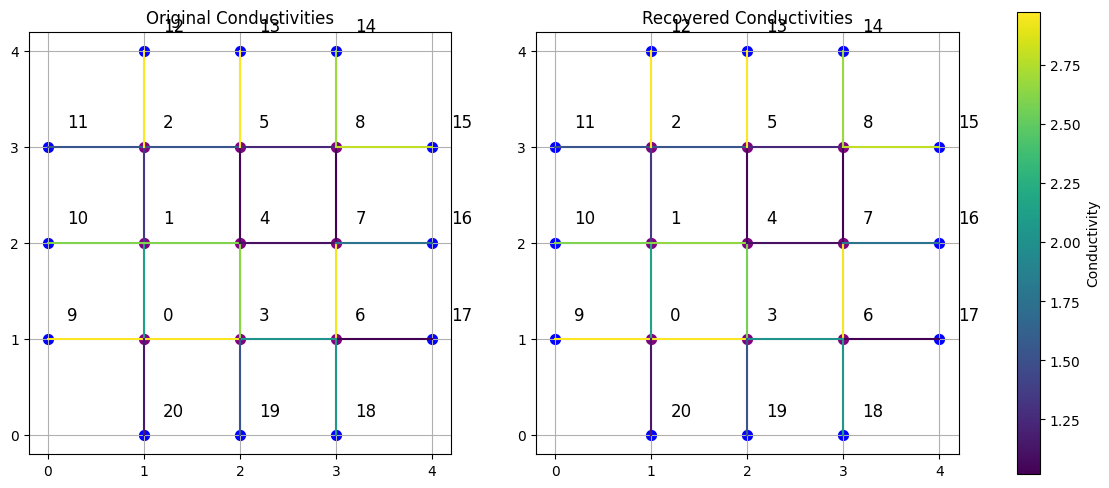



.........................................


.........................................


for n =  3
the batch size used for this training is  11
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.137771        2.150904       
(0,3)      2.975587        2.955099       
(0,9)      2.975587        2.976106       
(0,20)     1.145108        1.145045       
(1,2)      1.340625        1.343612       
(1,4)      2.605040        2.633048       
(1,10)     2.605040        2.599486       
(2,5)      1.527099        1.526171       
(2,11)     1.527099        1.527458       
(2,12)     2.964029        2.963178       
(3,4)      2.631639        2.571275       
(3,6)      2.014436        2.013734       
(3,19)     1.538321        1.540787       
(4,5)      1.046260        1.047086       
(4,7)      1.096460        1.096708       
(5,8)      1.234876        1.234380       
(5,13)     2.962038        2.962900       
(6,7)   

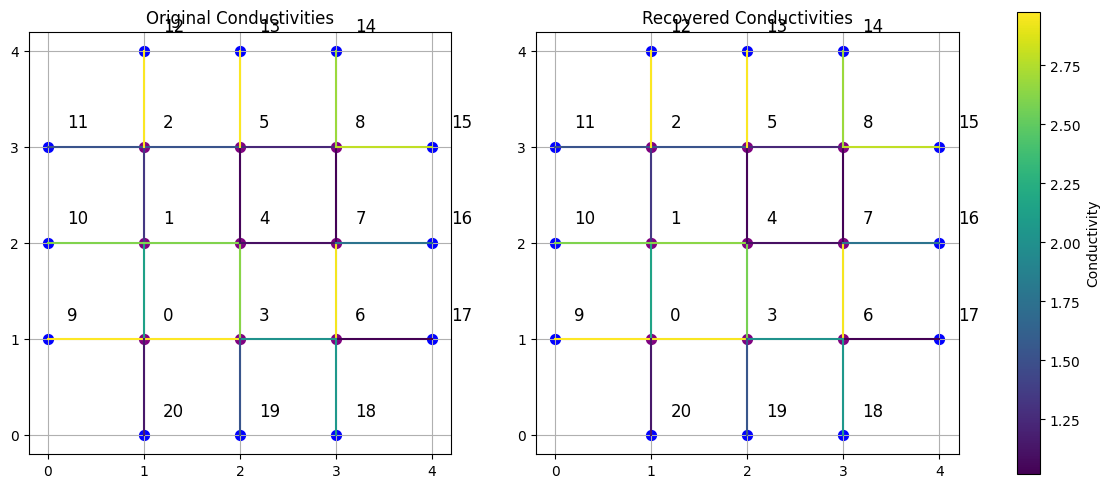



.........................................


.........................................


for n =  3
the batch size used for this training is  10
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.137771        2.161402       
(0,3)      2.975587        2.953016       
(0,9)      2.975587        2.974610       
(0,20)     1.145108        1.145631       
(1,2)      1.340625        1.343307       
(1,4)      2.605040        2.660351       
(1,10)     2.605040        2.595610       
(2,5)      1.527099        1.529753       
(2,11)     1.527099        1.527280       
(2,12)     2.964029        2.963633       
(3,4)      2.631639        2.518227       
(3,6)      2.014436        2.020872       
(3,19)     1.538321        1.540599       
(4,5)      1.046260        1.053839       
(4,7)      1.096460        1.083688       
(5,8)      1.234876        1.239015       
(5,13)     2.962038        2.953705       
(6,7)   

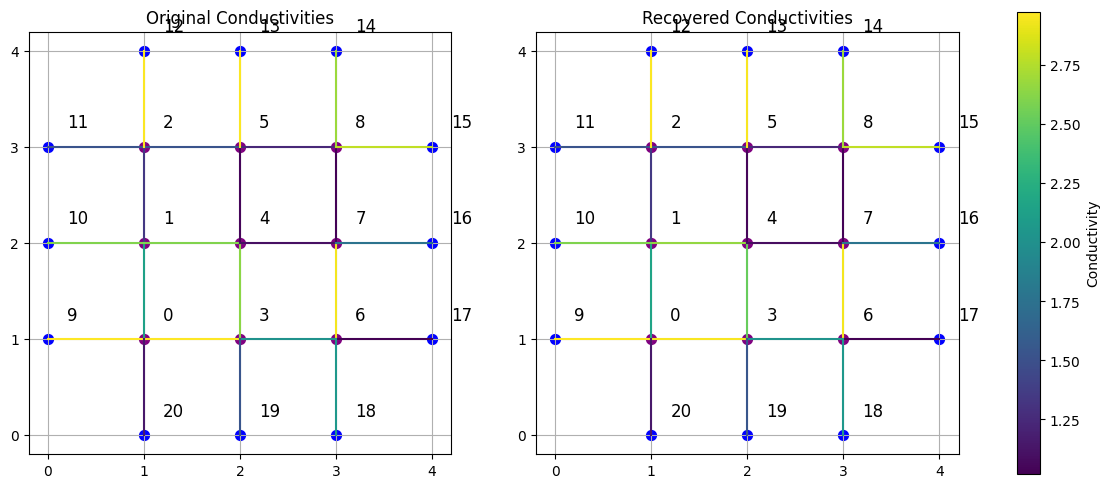



.........................................


.........................................


for n =  3
the batch size used for this training is  9
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.137771        2.161858       
(0,3)      2.975587        2.962340       
(0,9)      2.975587        2.972395       
(0,20)     1.145108        1.146833       
(1,2)      1.340625        1.345324       
(1,4)      2.605040        2.673985       
(1,10)     2.605040        2.595069       
(2,5)      1.527099        1.521828       
(2,11)     1.527099        1.527092       
(2,12)     2.964029        2.964206       
(3,4)      2.631639        2.496233       
(3,6)      2.014436        2.023900       
(3,19)     1.538321        1.544299       
(4,5)      1.046260        1.044115       
(4,7)      1.096460        1.084251       
(5,8)      1.234876        1.233022       
(5,13)     2.962038        2.967868       
(6,7)    

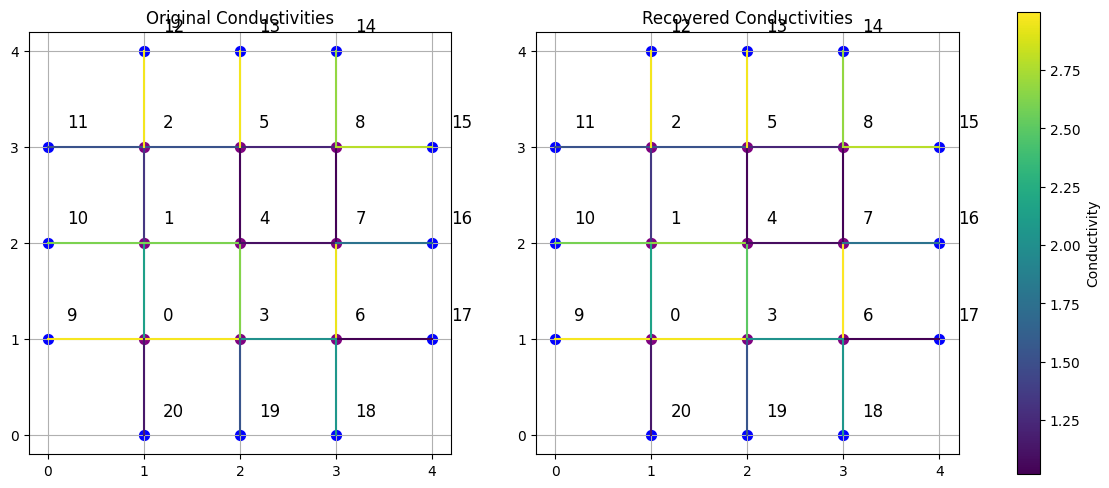



.........................................


.........................................


for n =  3
the batch size used for this training is  8
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.137771        2.173635       
(0,3)      2.975587        2.979819       
(0,9)      2.975587        2.964277       
(0,20)     1.145108        1.150573       
(1,2)      1.340625        1.343994       
(1,4)      2.605040        2.615368       
(1,10)     2.605040        2.597628       
(2,5)      1.527099        1.526618       
(2,11)     1.527099        1.527255       
(2,12)     2.964029        2.963574       
(3,4)      2.631639        2.528665       
(3,6)      2.014436        2.044739       
(3,19)     1.538321        1.547319       
(4,5)      1.046260        1.051135       
(4,7)      1.096460        1.093329       
(5,8)      1.234876        1.234692       
(5,13)     2.962038        2.960754       
(6,7)    

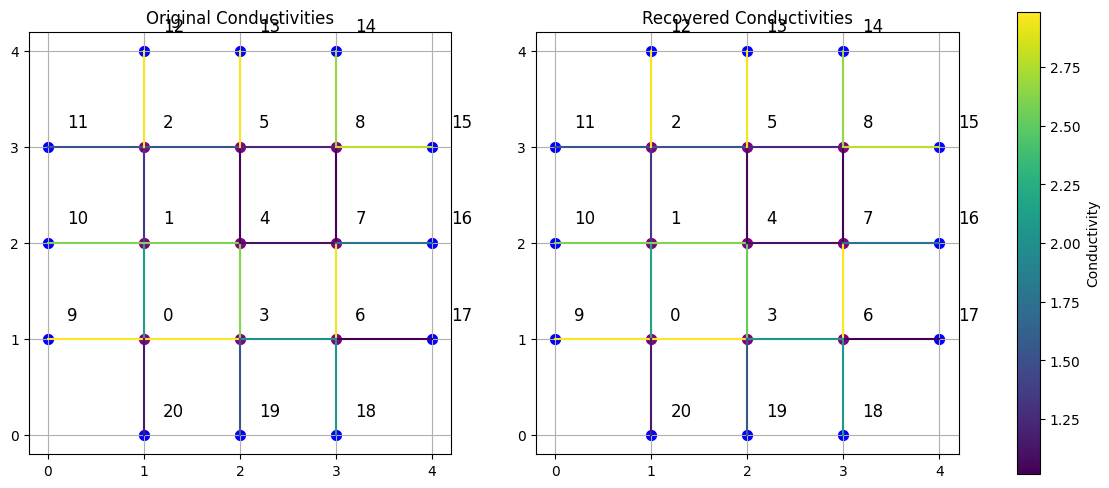



.........................................


.........................................


for n =  3
the batch size used for this training is  7
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.137771        2.138631       
(0,3)      2.975587        3.024643       
(0,9)      2.975587        2.970861       
(0,20)     1.145108        1.147412       
(1,2)      1.340625        1.338961       
(1,4)      2.605040        2.621472       
(1,10)     2.605040        2.602941       
(2,5)      1.527099        1.536116       
(2,11)     1.527099        1.527386       
(2,12)     2.964029        2.962640       
(3,4)      2.631639        2.659185       
(3,6)      2.014436        1.937831       
(3,19)     1.538321        1.522533       
(4,5)      1.046260        1.055439       
(4,7)      1.096460        1.113706       
(5,8)      1.234876        1.241157       
(5,13)     2.962038        2.946670       
(6,7)    

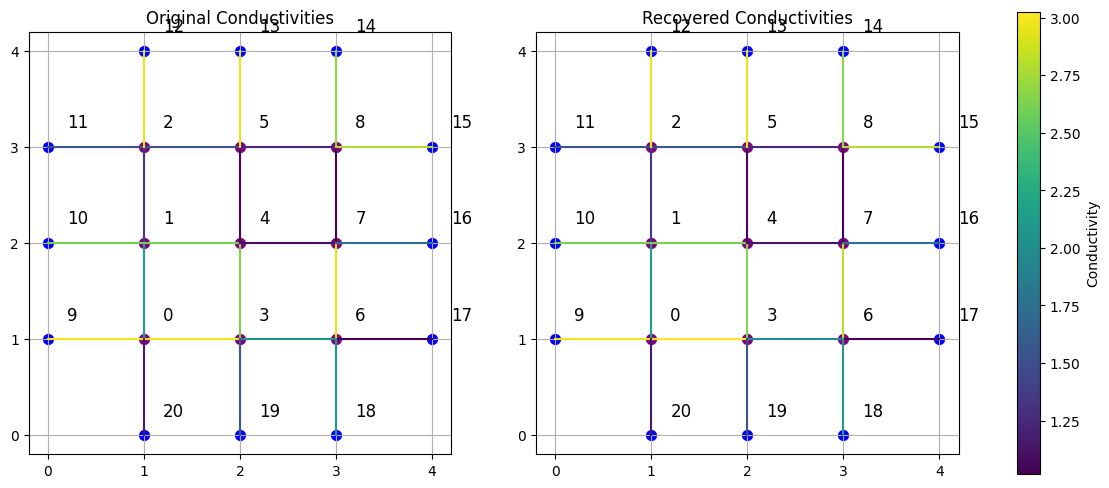



.........................................


.........................................


for n =  3
the batch size used for this training is  6
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.137771        2.132859       
(0,3)      2.975587        3.038040       
(0,9)      2.975587        2.969045       
(0,20)     1.145108        1.148109       
(1,2)      1.340625        1.338016       
(1,4)      2.605040        2.595833       
(1,10)     2.605040        2.607608       
(2,5)      1.527099        1.534083       
(2,11)     1.527099        1.527388       
(2,12)     2.964029        2.963118       
(3,4)      2.631639        2.686548       
(3,6)      2.014436        1.964580       
(3,19)     1.538321        1.521093       
(4,5)      1.046260        1.051460       
(4,7)      1.096460        1.100648       
(5,8)      1.234876        1.239695       
(5,13)     2.962038        2.951522       
(6,7)    

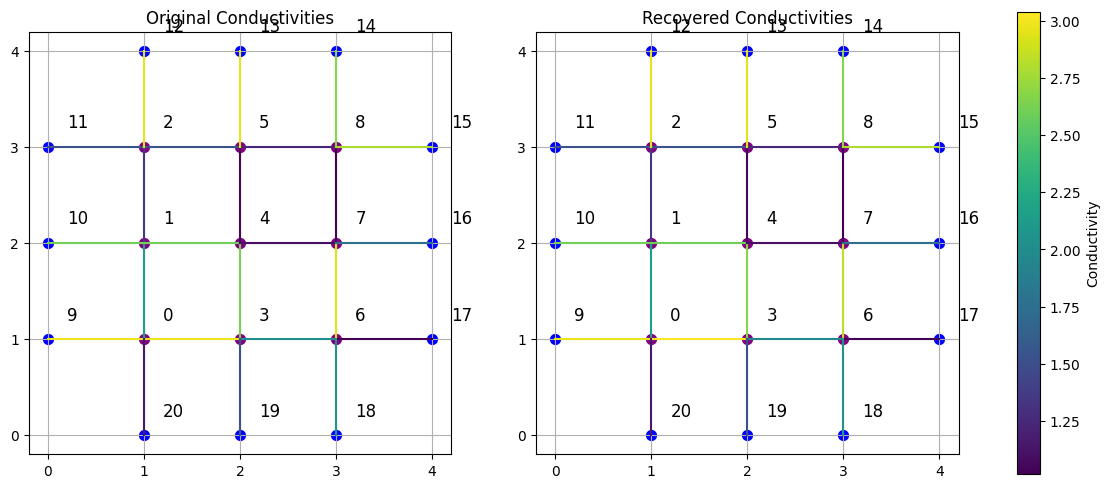



.........................................


.........................................


for n =  3
the batch size used for this training is  5
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.137771        2.055878       
(0,3)      2.975587        3.207059       
(0,9)      2.975587        2.972227       
(0,20)     1.145108        1.146711       
(1,2)      1.340625        1.322607       
(1,4)      2.605040        2.558088       
(1,10)     2.605040        2.628535       
(2,5)      1.527099        1.554129       
(2,11)     1.527099        1.527398       
(2,12)     2.964029        2.962869       
(3,4)      2.631639        2.852119       
(3,6)      2.014436        2.401130       
(3,19)     1.538321        1.463945       
(4,5)      1.046260        1.000744       
(4,7)      1.096460        1.700556       
(5,8)      1.234876        1.568946       
(5,13)     2.962038        2.923581       
(6,7)    

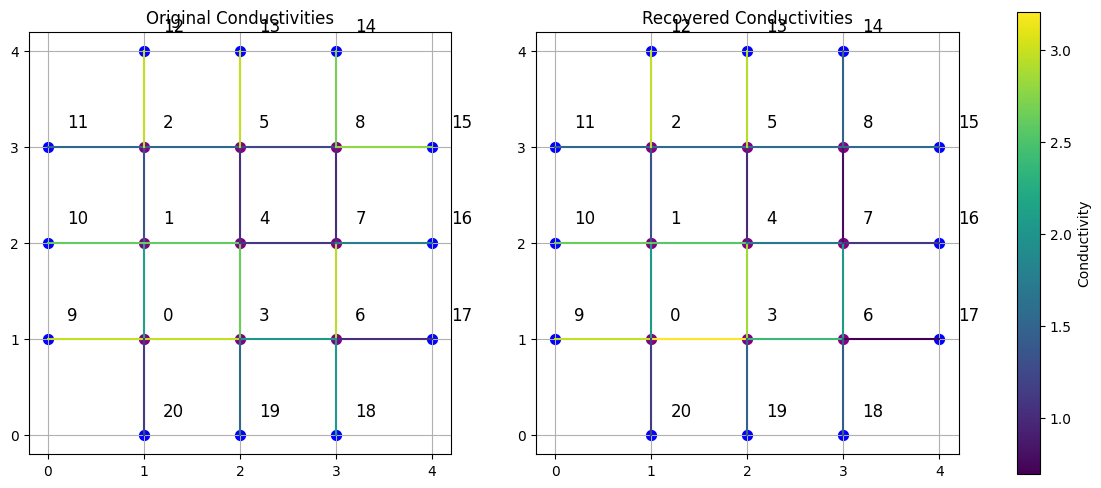



.........................................


.........................................


for n =  3
the batch size used for this training is  4
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.137771        2.036598       
(0,3)      2.975587        3.303386       
(0,9)      2.975587        2.970448       
(0,20)     1.145108        1.147445       
(1,2)      1.340625        1.325203       
(1,4)      2.605040        2.654699       
(1,10)     2.605040        2.621778       
(2,5)      1.527099        1.558625       
(2,11)     1.527099        1.527216       
(2,12)     2.964029        2.963532       
(3,4)      2.631639        2.956975       
(3,6)      2.014436        2.432500       
(3,19)     1.538321        1.434589       
(4,5)      1.046260        0.988211       
(4,7)      1.096460        1.729408       
(5,8)      1.234876        1.442769       
(5,13)     2.962038        2.868435       
(6,7)    

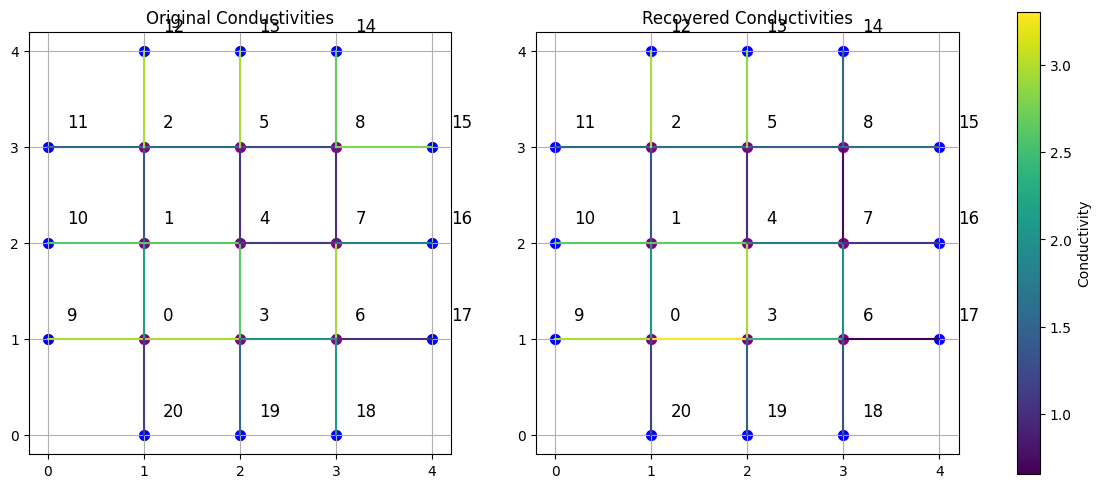



.........................................


.........................................


for n =  3
the batch size used for this training is  3
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.137771        2.030353       
(0,3)      2.975587        3.203280       
(0,9)      2.975587        2.973035       
(0,20)     1.145108        1.146605       
(1,2)      1.340625        1.290962       
(1,4)      2.605040        2.519657       
(1,10)     2.605040        2.646607       
(2,5)      1.527099        1.662096       
(2,11)     1.527099        1.524906       
(2,12)     2.964029        2.979357       
(3,4)      2.631639        2.894540       
(3,6)      2.014436        2.496437       
(3,19)     1.538321        1.474375       
(4,5)      1.046260        1.075754       
(4,7)      1.096460        1.589099       
(5,8)      1.234876        1.386587       
(5,13)     2.962038        2.678081       
(6,7)    

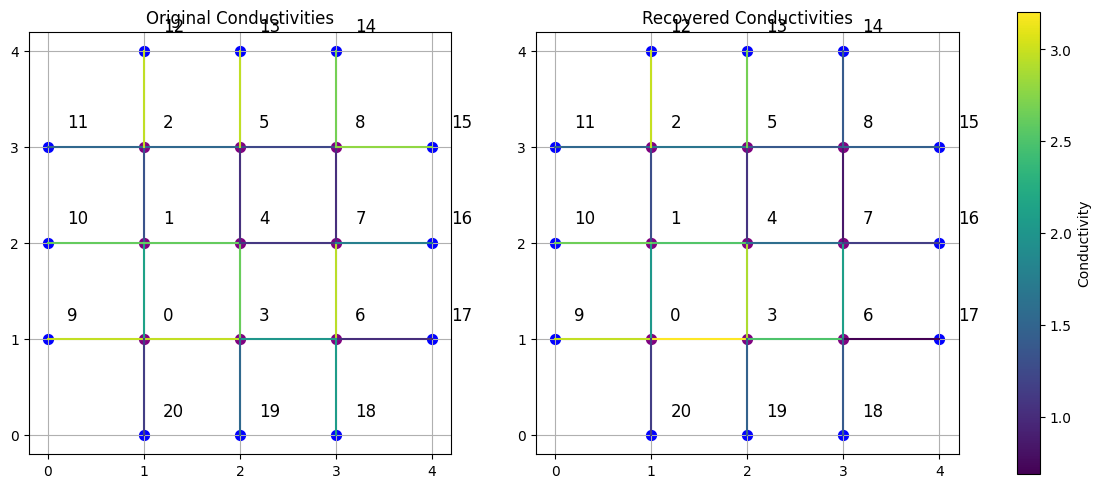



.........................................


.........................................


for n =  3
the batch size used for this training is  2
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.137771        2.189041       
(0,3)      2.975587        2.920996       
(0,9)      2.975587        2.973379       
(0,20)     1.145108        1.146177       
(1,2)      1.340625        2.400873       
(1,4)      2.605040        2.220640       
(1,10)     2.605040        2.579255       
(2,5)      1.527099        1.179956       
(2,11)     1.527099        0.666866       
(2,12)     2.964029        1.294209       
(3,4)      2.631639        2.863176       
(3,6)      2.014436        2.467745       
(3,19)     1.538321        1.548588       
(4,5)      1.046260        1.114001       
(4,7)      1.096460        1.581358       
(5,8)      1.234876        0.951963       
(5,13)     2.962038        1.584748       
(6,7)    

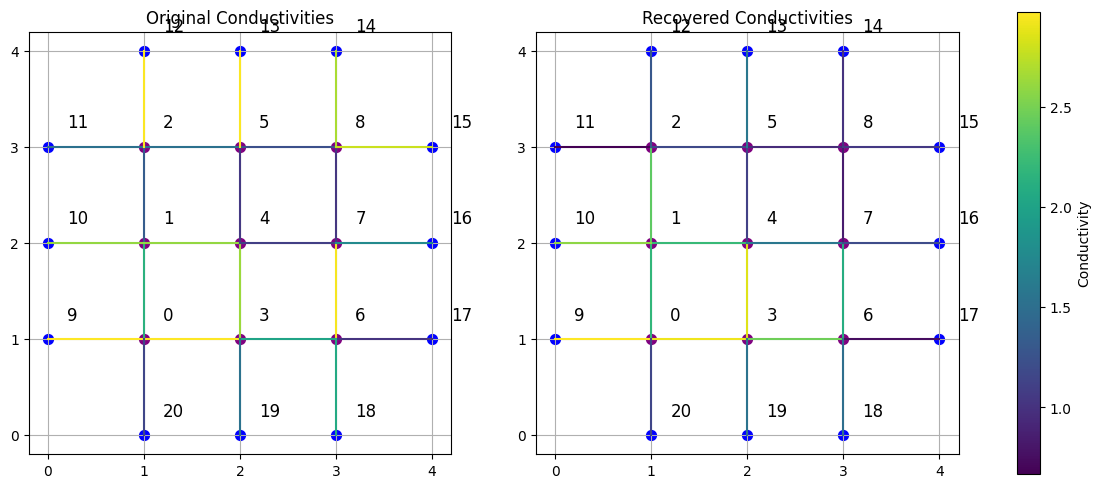



.........................................




In [13]:

run_demo_batch(3)

.........................................


for n =  4
the batch size used for this training is  16
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.011633        1.023283       
(0,4)      2.874197        2.852116       
(0,16)     2.874197        2.874805       
(0,31)     1.145108        1.145061       
(1,2)      2.876746        3.059720       
(1,5)      2.939448        2.855521       
(1,17)     2.939448        2.912095       
(2,3)      1.340625        1.342248       
(2,6)      2.356218        2.334878       
(2,18)     2.356218        2.341173       
(3,7)      1.527099        1.533000       
(3,19)     1.527099        1.527293       
(3,20)     2.362475        2.362385       
(4,5)      1.076150        1.087865       
(4,8)      2.295554        2.272253       
(4,30)     1.538321        1.541395       
(5,6)      2.999045        2.237742       
(5,9)      1.471560        1.679758       
(6,7)      

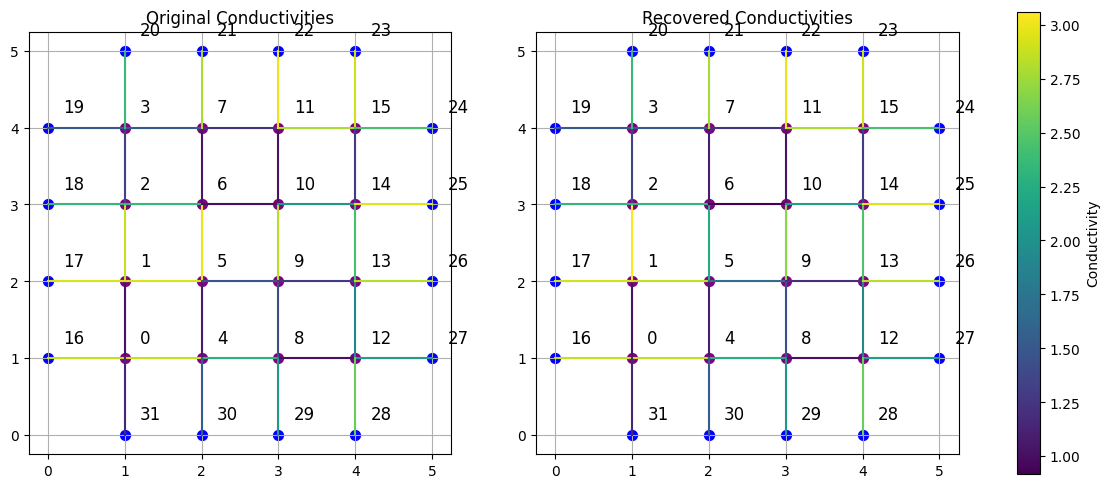



.........................................


.........................................


for n =  4
the batch size used for this training is  15
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.011633        1.034311       
(0,4)      2.874197        2.875378       
(0,16)     2.874197        2.864569       
(0,31)     1.145108        1.149079       
(1,2)      2.876746        3.094379       
(1,5)      2.939448        2.805854       
(1,17)     2.939448        2.905911       
(2,3)      1.340625        1.345092       
(2,6)      2.356218        2.311742       
(2,18)     2.356218        2.338247       
(3,7)      1.527099        1.531659       
(3,19)     1.527099        1.527330       
(3,20)     2.362475        2.362317       
(4,5)      1.076150        1.080990       
(4,8)      2.295554        2.282914       
(4,30)     1.538321        1.540365       
(5,6)      2.999045        2.171691       
(5,9)   

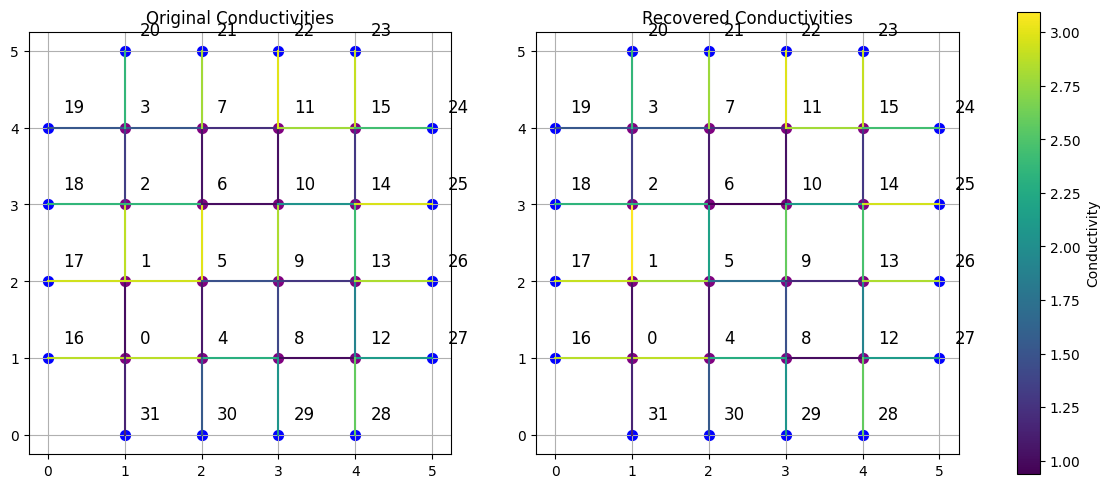



.........................................


.........................................


for n =  4
the batch size used for this training is  14
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.011633        1.043530       
(0,4)      2.874197        2.881399       
(0,16)     2.874197        2.857778       
(0,31)     1.145108        1.152523       
(1,2)      2.876746        3.102812       
(1,5)      2.939448        2.832417       
(1,17)     2.939448        2.901844       
(2,3)      1.340625        1.344011       
(2,6)      2.356218        2.307364       
(2,18)     2.356218        2.338403       
(3,7)      1.527099        1.537161       
(3,19)     1.527099        1.527258       
(3,20)     2.362475        2.361967       
(4,5)      1.076150        1.047538       
(4,8)      2.295554        2.288547       
(4,30)     1.538321        1.544075       
(5,6)      2.999045        2.132308       
(5,9)   

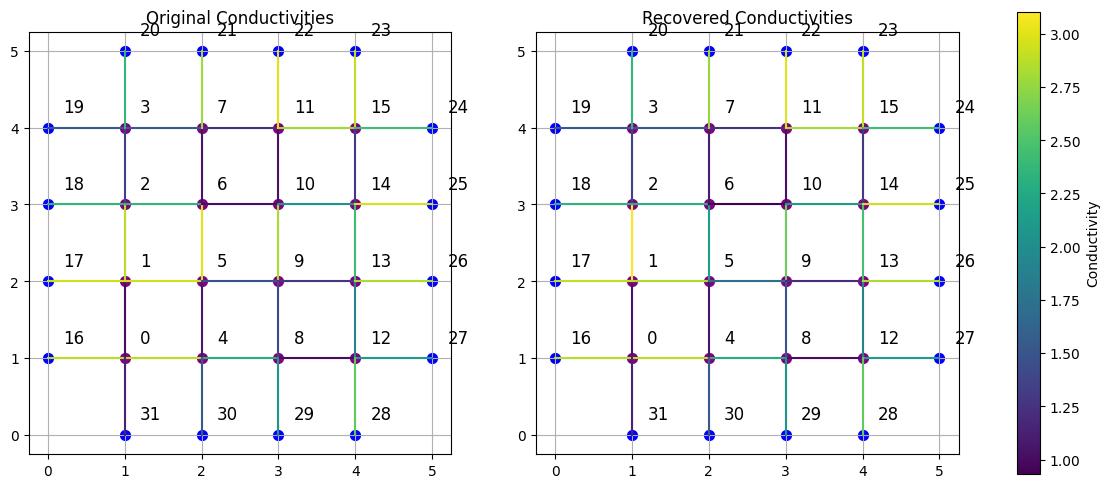



.........................................


.........................................


for n =  4
the batch size used for this training is  13
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.011633        1.040077       
(0,4)      2.874197        2.915547       
(0,16)     2.874197        2.853483       
(0,31)     1.145108        1.154524       
(1,2)      2.876746        3.104776       
(1,5)      2.939448        2.820353       
(1,17)     2.939448        2.900127       
(2,3)      1.340625        1.343624       
(2,6)      2.356218        2.196814       
(2,18)     2.356218        2.344648       
(3,7)      1.527099        1.535200       
(3,19)     1.527099        1.527437       
(3,20)     2.362475        2.361880       
(4,5)      1.076150        1.069626       
(4,8)      2.295554        2.268576       
(4,30)     1.538321        1.534124       
(5,6)      2.999045        2.111914       
(5,9)   

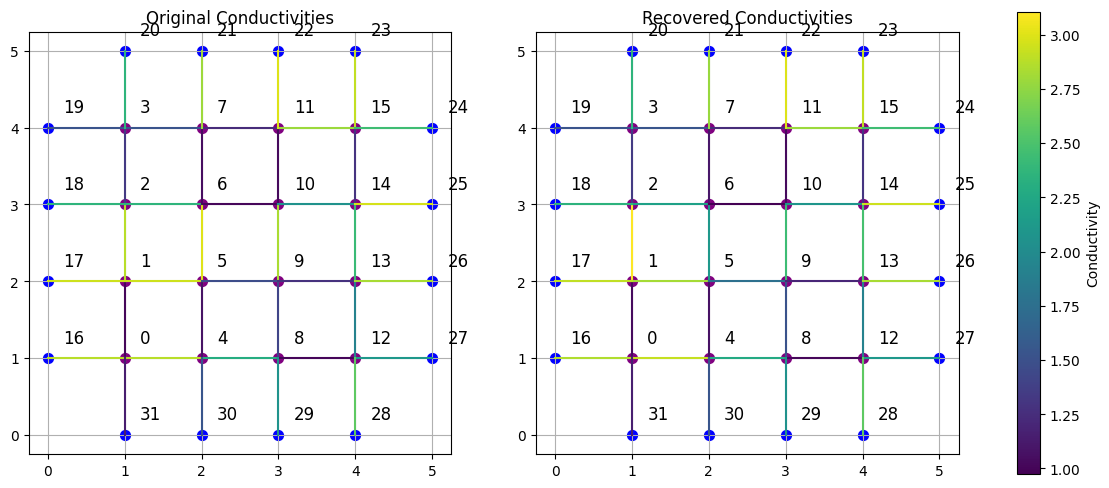



.........................................


.........................................


for n =  4
the batch size used for this training is  12
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.011633        1.040446       
(0,4)      2.874197        2.919269       
(0,16)     2.874197        2.849695       
(0,31)     1.145108        1.156715       
(1,2)      2.876746        3.066734       
(1,5)      2.939448        2.868496       
(1,17)     2.939448        2.901301       
(2,3)      1.340625        1.338704       
(2,6)      2.356218        2.210658       
(2,18)     2.356218        2.348837       
(3,7)      1.527099        1.540429       
(3,19)     1.527099        1.527407       
(3,20)     2.362475        2.361908       
(4,5)      1.076150        1.070840       
(4,8)      2.295554        2.283208       
(4,30)     1.538321        1.537412       
(5,6)      2.999045        2.244627       
(5,9)   

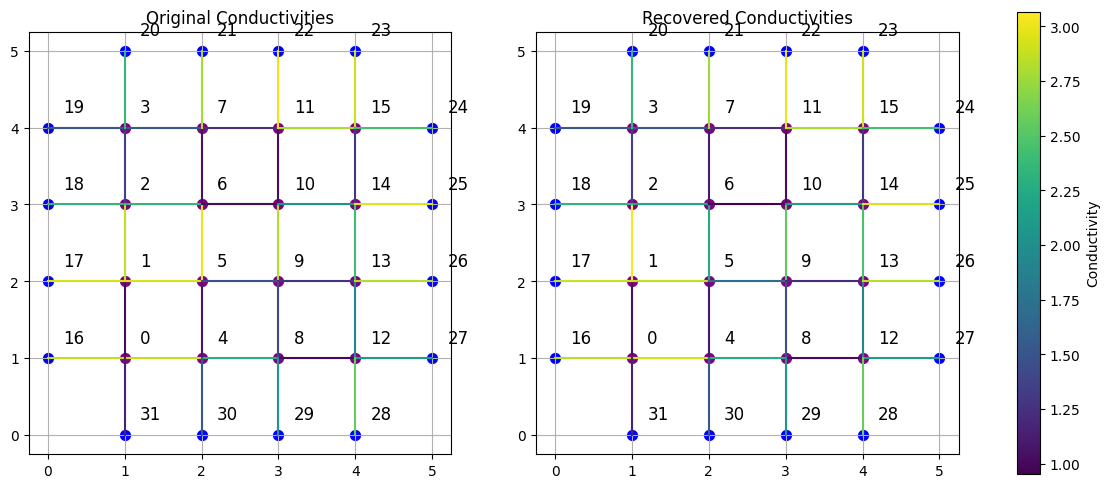



.........................................


.........................................


for n =  4
the batch size used for this training is  11
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.011633        1.048730       
(0,4)      2.874197        2.792788       
(0,16)     2.874197        2.874371       
(0,31)     1.145108        1.145180       
(1,2)      2.876746        3.065708       
(1,5)      2.939448        2.980160       
(1,17)     2.939448        2.880458       
(2,3)      1.340625        1.342520       
(2,6)      2.356218        2.190157       
(2,18)     2.356218        2.352097       
(3,7)      1.527099        1.533638       
(3,19)     1.527099        1.527221       
(3,20)     2.362475        2.361587       
(4,5)      1.076150        1.058790       
(4,8)      2.295554        2.266857       
(4,30)     1.538321        1.558501       
(5,6)      2.999045        2.570433       
(5,9)   

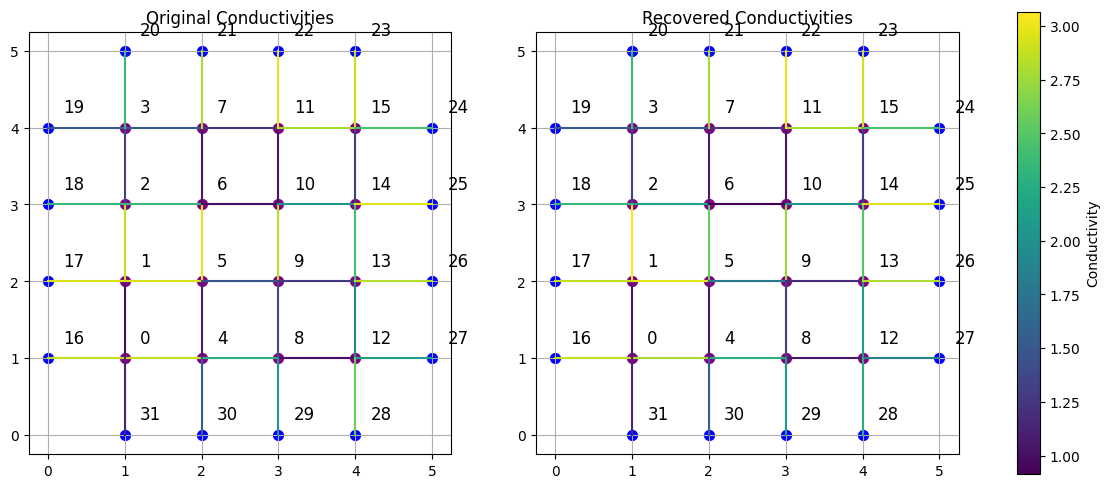



.........................................


.........................................


for n =  4
the batch size used for this training is  10
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.011633        1.072291       
(0,4)      2.874197        2.803272       
(0,16)     2.874197        2.853483       
(0,31)     1.145108        1.154094       
(1,2)      2.876746        3.187029       
(1,5)      2.939448        2.958853       
(1,17)     2.939448        2.854032       
(2,3)      1.340625        1.345069       
(2,6)      2.356218        2.051730       
(2,18)     2.356218        2.348461       
(3,7)      1.527099        1.525993       
(3,19)     1.527099        1.527338       
(3,20)     2.362475        2.361772       
(4,5)      1.076150        1.073505       
(4,8)      2.295554        2.271089       
(4,30)     1.538321        1.577687       
(5,6)      2.999045        2.237494       
(5,9)   

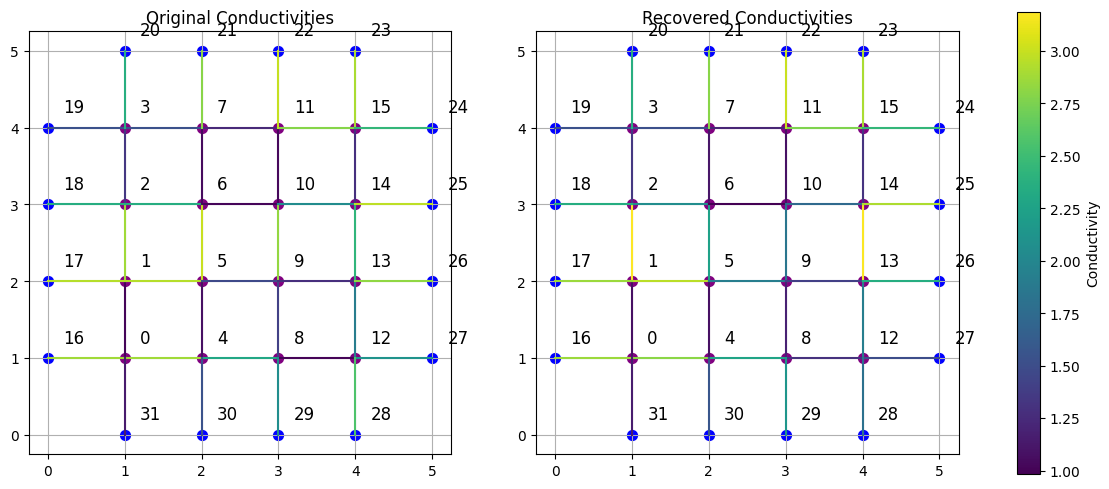



.........................................


.........................................


for n =  4
the batch size used for this training is  9
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.011633        1.078292       
(0,4)      2.874197        2.671178       
(0,16)     2.874197        2.873238       
(0,31)     1.145108        1.146122       
(1,2)      2.876746        3.097087       
(1,5)      2.939448        2.955733       
(1,17)     2.939448        2.873097       
(2,3)      1.340625        1.344251       
(2,6)      2.356218        2.183370       
(2,18)     2.356218        2.349985       
(3,7)      1.527099        1.526466       
(3,19)     1.527099        1.527356       
(3,20)     2.362475        2.362247       
(4,5)      1.076150        1.009641       
(4,8)      2.295554        2.318904       
(4,30)     1.538321        1.626504       
(5,6)      2.999045        2.507748       
(5,9)    

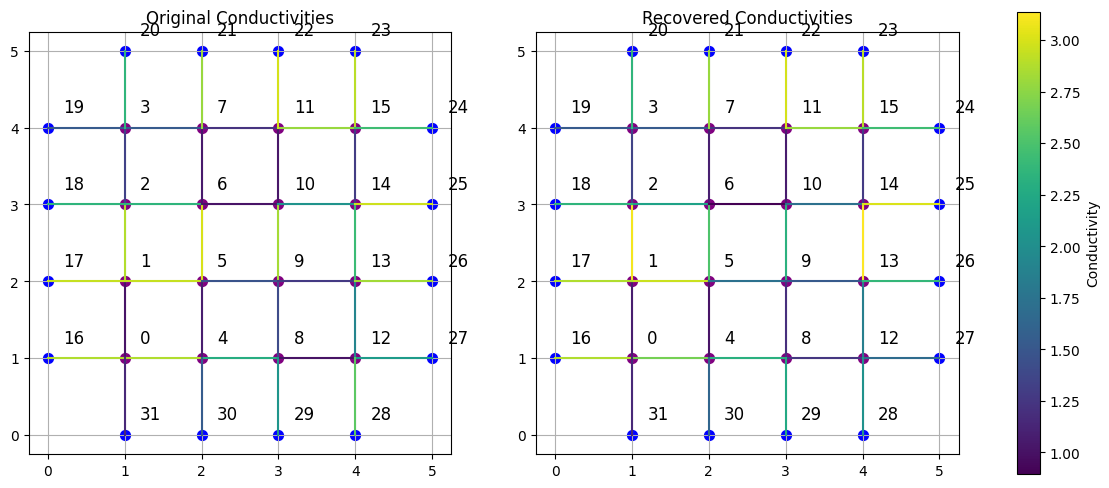



.........................................


.........................................


for n =  4
the batch size used for this training is  8
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.011633        1.088277       
(0,4)      2.874197        2.692295       
(0,16)     2.874197        2.859318       
(0,31)     1.145108        1.152155       
(1,2)      2.876746        3.092234       
(1,5)      2.939448        2.913972       
(1,17)     2.939448        2.872966       
(2,3)      1.340625        1.342621       
(2,6)      2.356218        2.111438       
(2,18)     2.356218        2.354596       
(3,7)      1.527099        1.533343       
(3,19)     1.527099        1.527339       
(3,20)     2.362475        2.361707       
(4,5)      1.076150        1.006043       
(4,8)      2.295554        2.344530       
(4,30)     1.538321        1.628406       
(5,6)      2.999045        2.577310       
(5,9)    

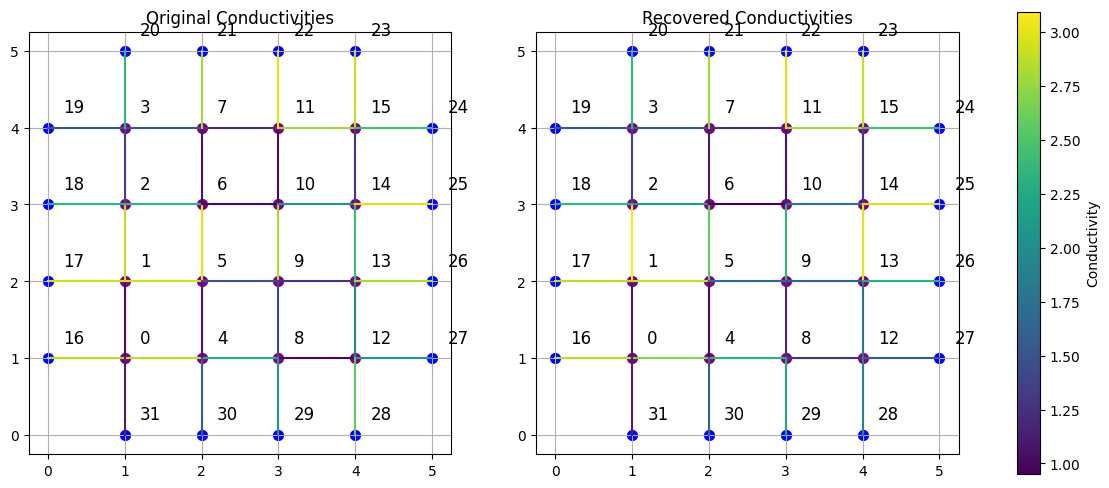



.........................................


.........................................


for n =  4
the batch size used for this training is  7
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.011633        1.087924       
(0,4)      2.874197        2.634829       
(0,16)     2.874197        2.875152       
(0,31)     1.145108        1.145443       
(1,2)      2.876746        3.197053       
(1,5)      2.939448        2.810486       
(1,17)     2.939448        2.864782       
(2,3)      1.340625        1.349941       
(2,6)      2.356218        2.114323       
(2,18)     2.356218        2.342618       
(3,7)      1.527099        1.526209       
(3,19)     1.527099        1.527349       
(3,20)     2.362475        2.361717       
(4,5)      1.076150        1.044796       
(4,8)      2.295554        2.254102       
(4,30)     1.538321        1.638635       
(5,6)      2.999045        2.185215       
(5,9)    

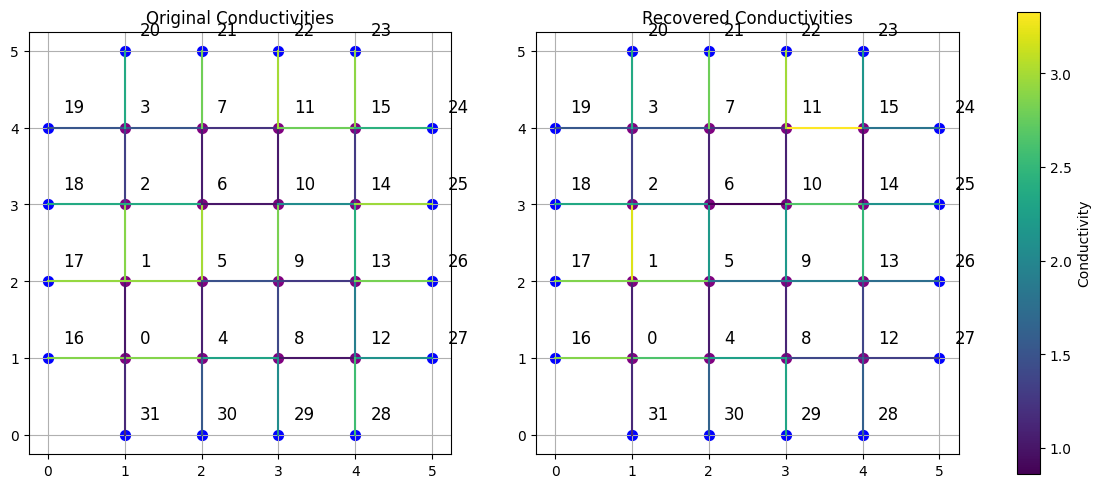



.........................................


.........................................


for n =  4
the batch size used for this training is  6
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.011633        0.995028       
(0,4)      2.874197        3.084449       
(0,16)     2.874197        2.862705       
(0,31)     1.145108        1.151063       
(1,2)      2.876746        3.008335       
(1,5)      2.939448        3.007087       
(1,17)     2.939448        2.905565       
(2,3)      1.340625        1.327141       
(2,6)      2.356218        2.007764       
(2,18)     2.356218        2.368467       
(3,7)      1.527099        1.552054       
(3,19)     1.527099        1.527312       
(3,20)     2.362475        2.361705       
(4,5)      1.076150        1.110553       
(4,8)      2.295554        2.403293       
(4,30)     1.538321        1.454566       
(5,6)      2.999045        2.153277       
(5,9)    

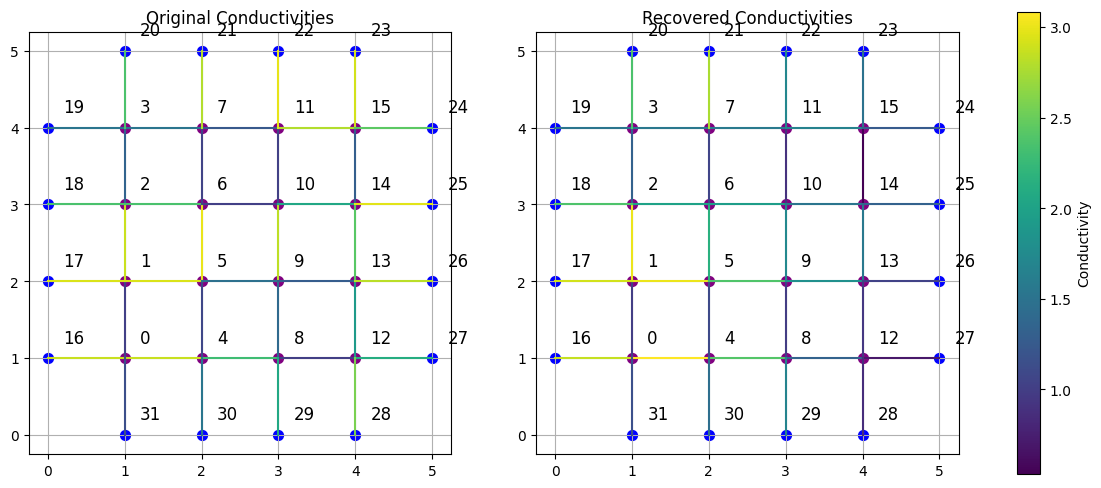



.........................................


.........................................


for n =  4
the batch size used for this training is  5
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.011633        0.989868       
(0,4)      2.874197        3.063430       
(0,16)     2.874197        2.864943       
(0,31)     1.145108        1.149312       
(1,2)      2.876746        3.003303       
(1,5)      2.939448        2.830514       
(1,17)     2.939448        2.925045       
(2,3)      1.340625        1.347277       
(2,6)      2.356218        2.147612       
(2,18)     2.356218        2.351792       
(3,7)      1.527099        1.519209       
(3,19)     1.527099        1.527249       
(3,20)     2.362475        2.362084       
(4,5)      1.076150        1.108745       
(4,8)      2.295554        2.515778       
(4,30)     1.538321        1.464036       
(5,6)      2.999045        2.289205       
(5,9)    

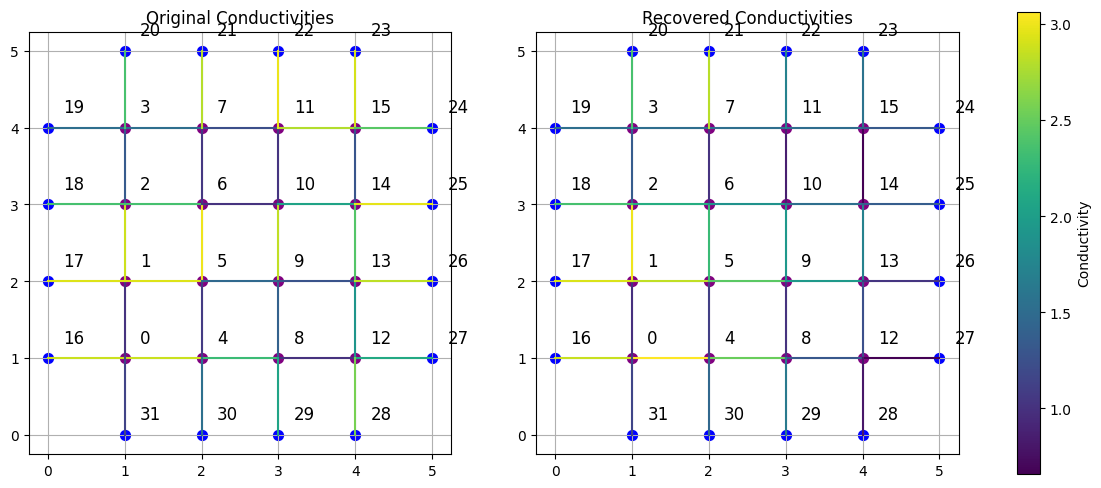



.........................................


.........................................


for n =  4
the batch size used for this training is  4
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.011633        1.008686       
(0,4)      2.874197        2.963234       
(0,16)     2.874197        2.865047       
(0,31)     1.145108        1.149773       
(1,2)      2.876746        2.993834       
(1,5)      2.939448        2.728190       
(1,17)     2.939448        2.927743       
(2,3)      1.340625        1.328682       
(2,6)      2.356218        2.104220       
(2,18)     2.356218        2.357379       
(3,7)      1.527099        1.559836       
(3,19)     1.527099        1.527233       
(3,20)     2.362475        2.361738       
(4,5)      1.076150        1.099577       
(4,8)      2.295554        2.543024       
(4,30)     1.538321        1.504786       
(5,6)      2.999045        2.328510       
(5,9)    

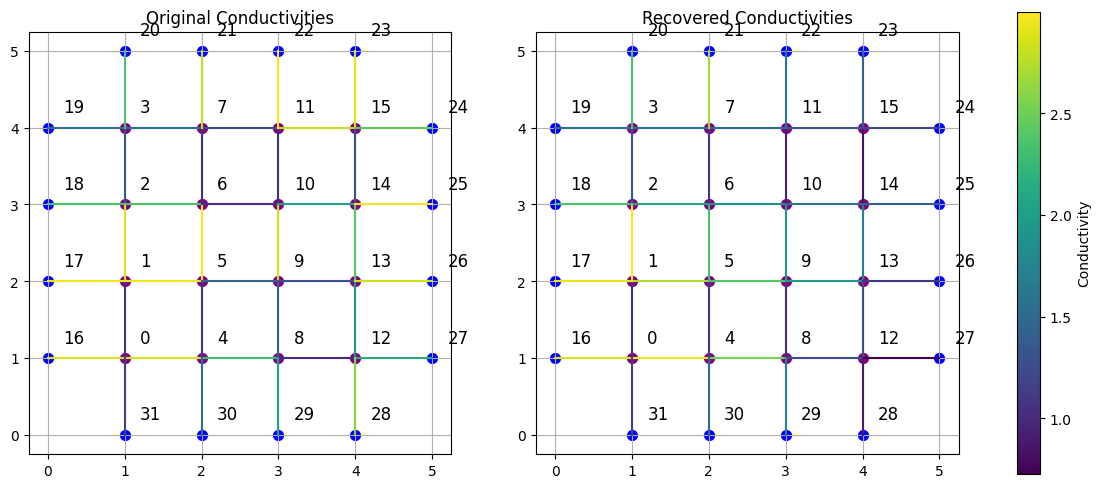



.........................................


.........................................


for n =  4
the batch size used for this training is  3
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.011633        1.013936       
(0,4)      2.874197        2.985506       
(0,16)     2.874197        2.857420       
(0,31)     1.145108        1.152854       
(1,2)      2.876746        3.163158       
(1,5)      2.939448        2.554424       
(1,17)     2.939448        2.917304       
(2,3)      1.340625        2.340204       
(2,6)      2.356218        1.942432       
(2,18)     2.356218        2.323497       
(3,7)      1.527099        0.943629       
(3,19)     1.527099        0.706467       
(3,20)     2.362475        1.093453       
(4,5)      1.076150        1.145983       
(4,8)      2.295554        2.487431       
(4,30)     1.538321        1.503271       
(5,6)      2.999045        2.169086       
(5,9)    

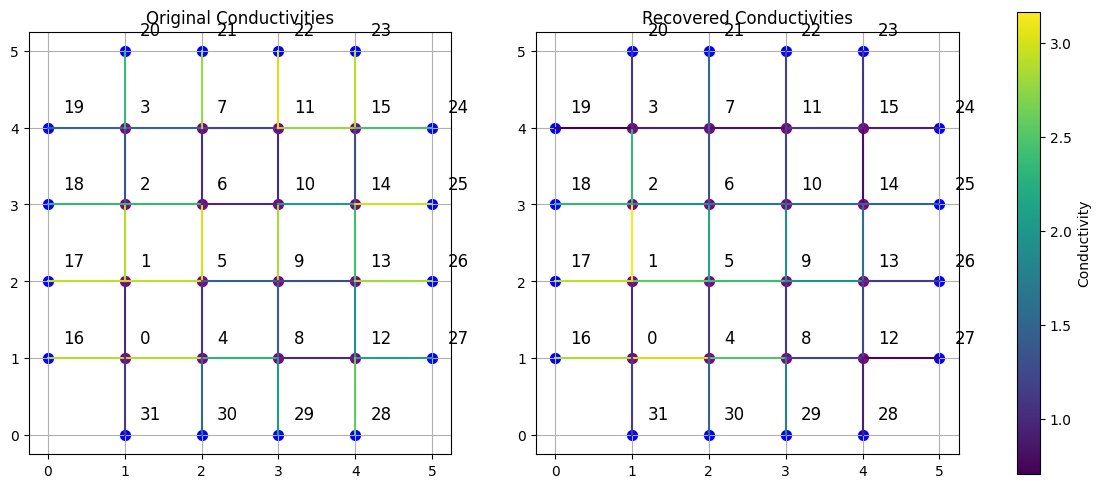



.........................................


.........................................


for n =  4
the batch size used for this training is  2
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.011633        1.009484       
(0,4)      2.874197        3.205756       
(0,16)     2.874197        2.853148       
(0,31)     1.145108        1.155146       
(1,2)      2.876746        3.693604       
(1,5)      2.939448        3.180187       
(1,17)     2.939448        2.853829       
(2,3)      1.340625        2.040061       
(2,6)      2.356218        1.292550       
(2,18)     2.356218        2.080951       
(3,7)      1.527099        0.895181       
(3,19)     1.527099        0.639512       
(3,20)     2.362475        0.987117       
(4,5)      1.076150        1.089429       
(4,8)      2.295554        2.413840       
(4,30)     1.538321        1.405571       
(5,6)      2.999045        1.760842       
(5,9)    

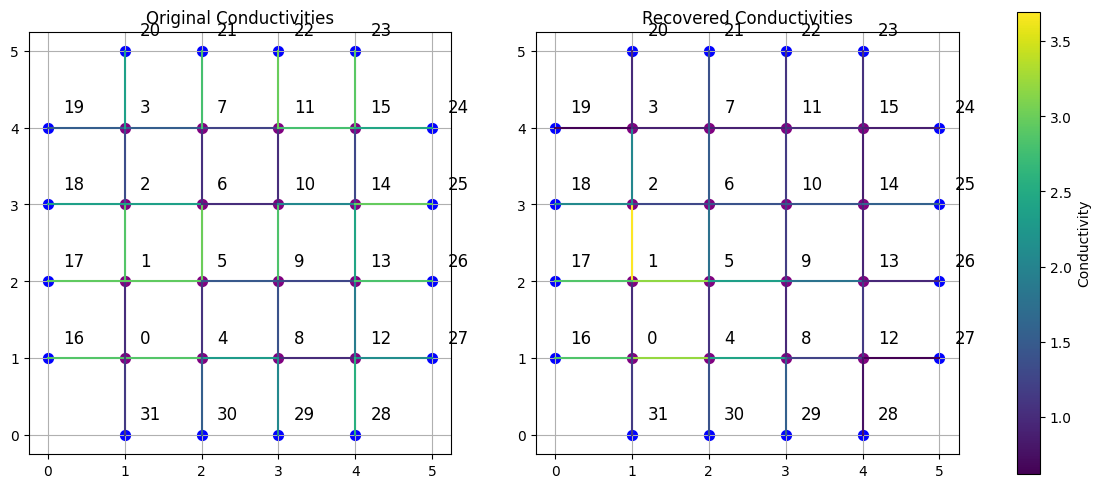



.........................................




In [14]:

run_demo_batch(4)

.........................................


for n =  5
the batch size used for this training is  20
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.703421        1.685504       
(0,5)      2.778593        2.792628       
(0,25)     2.778593        2.779159       
(0,44)     1.145108        1.144962       
(1,2)      1.430035        1.640447       
(1,6)      2.999975        2.374200       
(1,26)     2.999975        3.017289       
(2,3)      2.998389        3.469335       
(2,7)      2.769652        2.340661       
(2,27)     2.769652        2.681470       
(3,4)      1.340625        1.348703       
(3,8)      2.191664        1.595787       
(3,28)     2.191664        2.183748       
(4,9)      1.527099        1.534996       
(4,29)     1.527099        1.526985       
(4,30)     1.813514        1.812750       
(5,6)      1.250992        1.494723       
(5,10)     2.454130        2.295169       
(5,43)     

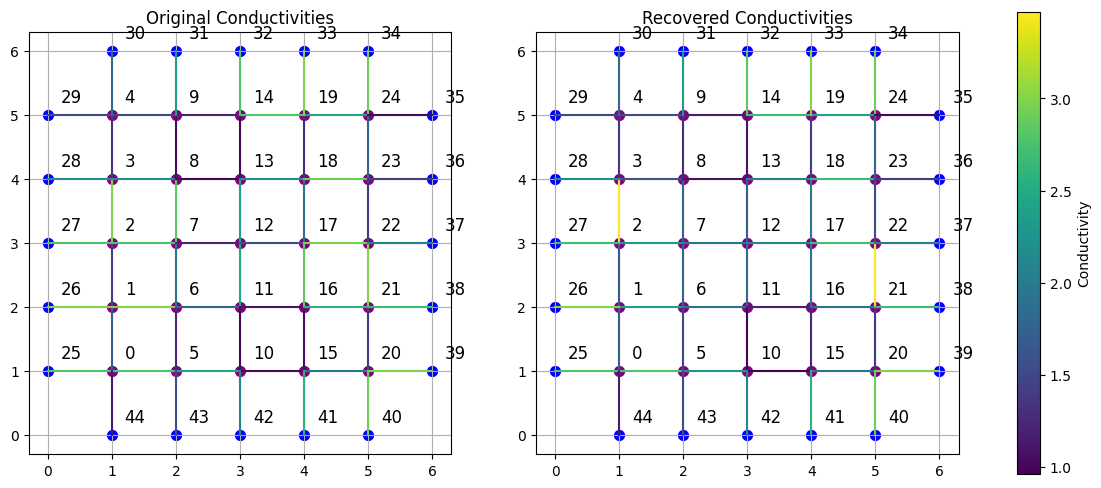



.........................................


.........................................


for n =  5
the batch size used for this training is  19
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.703421        1.696651       
(0,5)      2.778593        2.819998       
(0,25)     2.778593        2.772297       
(0,44)     1.145108        1.148153       
(1,2)      1.430035        1.648512       
(1,6)      2.999975        2.389846       
(1,26)     2.999975        3.008236       
(2,3)      2.998389        3.466292       
(2,7)      2.769652        2.332416       
(2,27)     2.769652        2.682304       
(3,4)      1.340625        1.345653       
(3,8)      2.191664        1.609564       
(3,28)     2.191664        2.184163       
(4,9)      1.527099        1.525765       
(4,29)     1.527099        1.527061       
(4,30)     1.813514        1.813645       
(5,6)      1.250992        1.492124       
(5,10)  

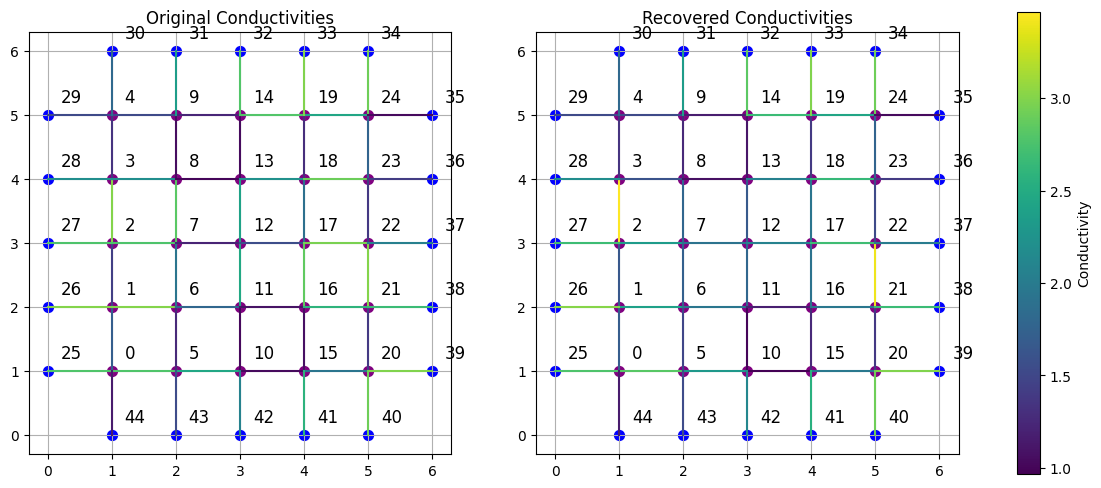



.........................................


.........................................


for n =  5
the batch size used for this training is  18
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.703421        1.727748       
(0,5)      2.778593        2.769269       
(0,25)     2.778593        2.774628       
(0,44)     1.145108        1.147648       
(1,2)      1.430035        1.701639       
(1,6)      2.999975        2.492663       
(1,26)     2.999975        2.969230       
(2,3)      2.998389        3.495723       
(2,7)      2.769652        2.334198       
(2,27)     2.769652        2.673441       
(3,4)      1.340625        1.357398       
(3,8)      2.191664        1.592671       
(3,28)     2.191664        2.181498       
(4,9)      1.527099        1.521629       
(4,29)     1.527099        1.527016       
(4,30)     1.813514        1.812739       
(5,6)      1.250992        1.462271       
(5,10)  

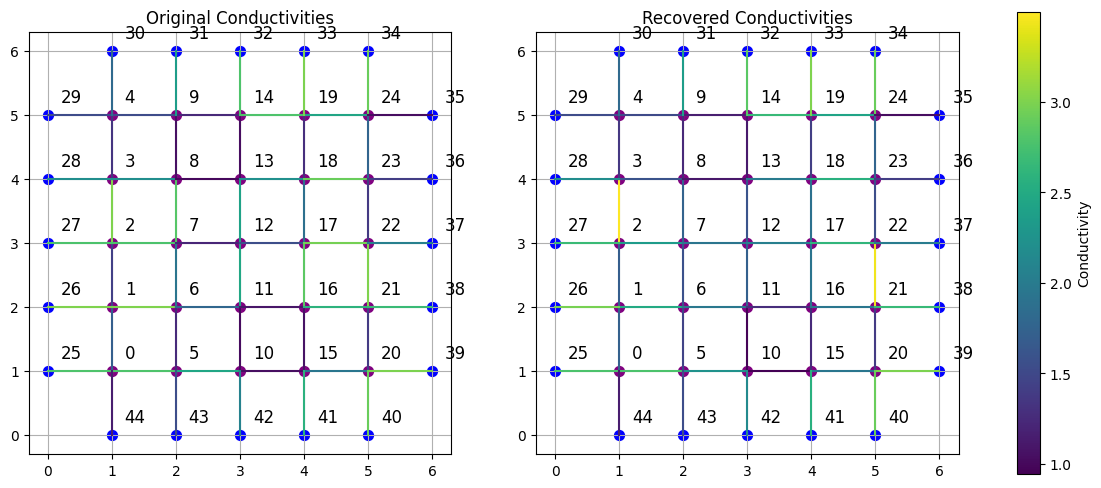



.........................................


.........................................


for n =  5
the batch size used for this training is  17
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.703421        1.791676       
(0,5)      2.778593        2.659429       
(0,25)     2.778593        2.768474       
(0,44)     1.145108        1.151144       
(1,2)      1.430035        1.742407       
(1,6)      2.999975        2.561531       
(1,26)     2.999975        2.929856       
(2,3)      2.998389        3.495278       
(2,7)      2.769652        2.255754       
(2,27)     2.769652        2.674624       
(3,4)      1.340625        1.349201       
(3,8)      2.191664        1.585749       
(3,28)     2.191664        2.182793       
(4,9)      1.527099        1.524089       
(4,29)     1.527099        1.527012       
(4,30)     1.813514        1.813309       
(5,6)      1.250992        1.342332       
(5,10)  

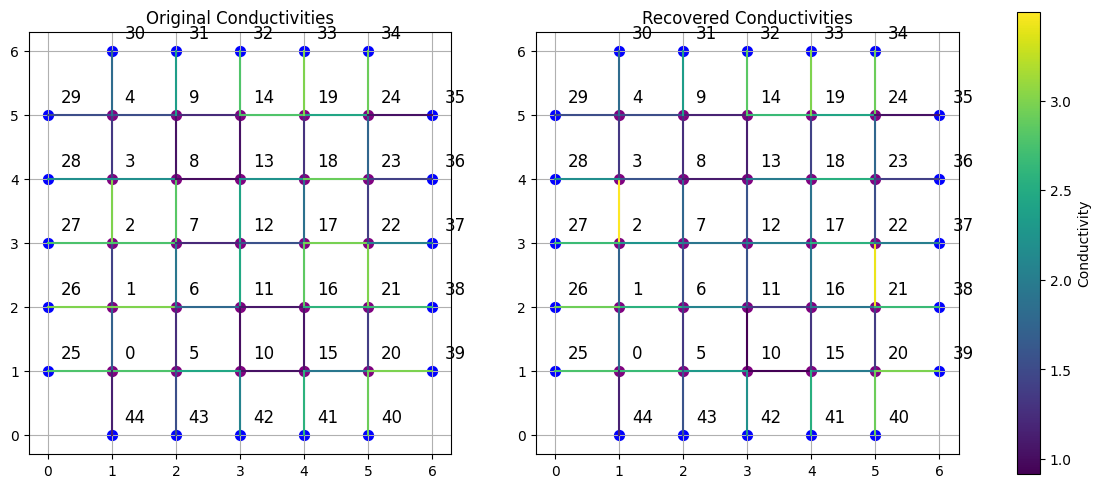



.........................................


.........................................


for n =  5
the batch size used for this training is  16
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.703421        1.782282       
(0,5)      2.778593        2.582965       
(0,25)     2.778593        2.782705       
(0,44)     1.145108        1.144256       
(1,2)      1.430035        1.734832       
(1,6)      2.999975        2.465481       
(1,26)     2.999975        2.943365       
(2,3)      2.998389        3.487588       
(2,7)      2.769652        2.242864       
(2,27)     2.769652        2.675302       
(3,4)      1.340625        1.345309       
(3,8)      2.191664        1.592490       
(3,28)     2.191664        2.183378       
(4,9)      1.527099        1.528005       
(4,29)     1.527099        1.527155       
(4,30)     1.813514        1.813517       
(5,6)      1.250992        1.308799       
(5,10)  

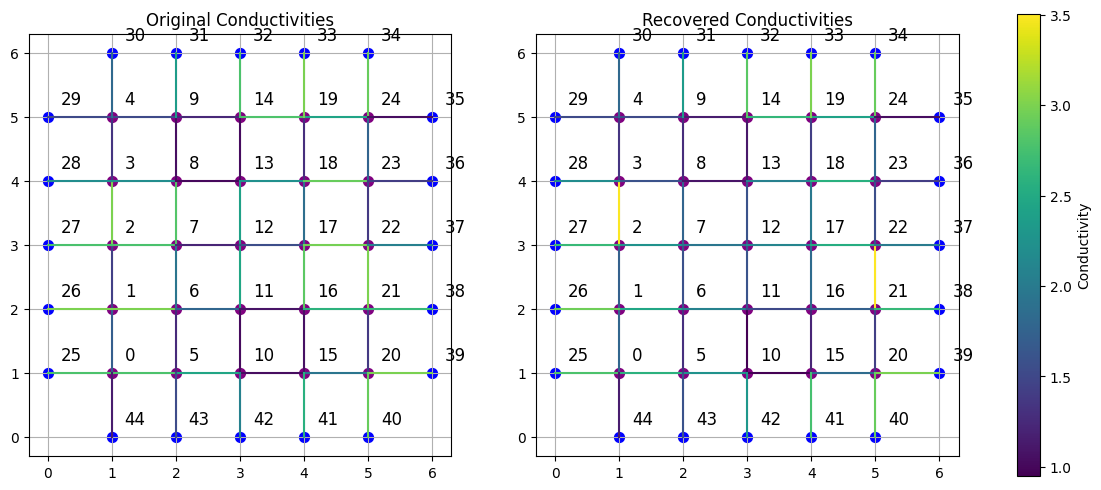



.........................................


.........................................


for n =  5
the batch size used for this training is  15
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.703421        1.805249       
(0,5)      2.778593        2.662873       
(0,25)     2.778593        2.761312       
(0,44)     1.145108        1.154545       
(1,2)      1.430035        1.710786       
(1,6)      2.999975        2.471070       
(1,26)     2.999975        2.942245       
(2,3)      2.998389        3.461596       
(2,7)      2.769652        2.245552       
(2,27)     2.769652        2.683667       
(3,4)      1.340625        1.346554       
(3,8)      2.191664        1.651814       
(3,28)     2.191664        2.182104       
(4,9)      1.527099        1.534016       
(4,29)     1.527099        1.527198       
(4,30)     1.813514        1.813228       
(5,6)      1.250992        1.307485       
(5,10)  

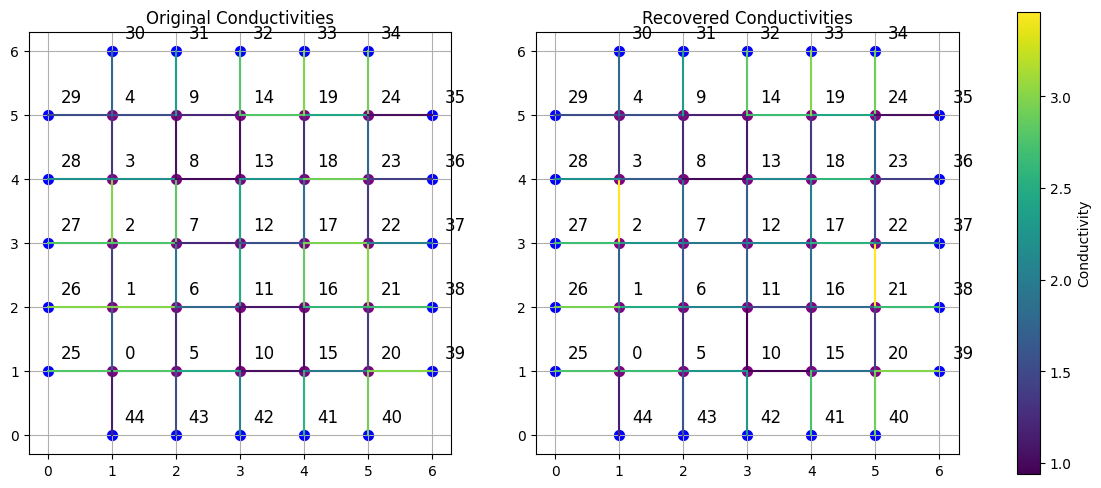



.........................................


.........................................


for n =  5
the batch size used for this training is  14
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.703421        1.728251       
(0,5)      2.778593        2.856284       
(0,25)     2.778593        2.764761       
(0,44)     1.145108        1.151375       
(1,2)      1.430035        1.632354       
(1,6)      2.999975        2.571774       
(1,26)     2.999975        2.978500       
(2,3)      2.998389        3.385649       
(2,7)      2.769652        2.377720       
(2,27)     2.769652        2.695595       
(3,4)      1.340625        1.341900       
(3,8)      2.191664        1.732036       
(3,28)     2.191664        2.186870       
(4,9)      1.527099        1.533622       
(4,29)     1.527099        1.527180       
(4,30)     1.813514        1.813386       
(5,6)      1.250992        1.351731       
(5,10)  

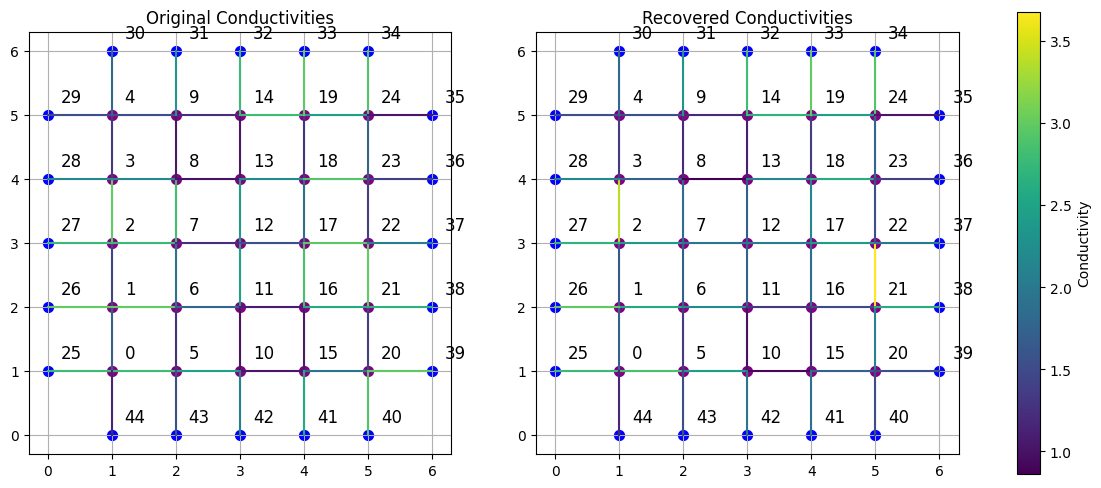



.........................................


.........................................


for n =  5
the batch size used for this training is  13
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.703421        1.754420       
(0,5)      2.778593        2.722083       
(0,25)     2.778593        2.768211       
(0,44)     1.145108        1.150493       
(1,2)      1.430035        1.645580       
(1,6)      2.999975        2.537459       
(1,26)     2.999975        2.974495       
(2,3)      2.998389        3.419728       
(2,7)      2.769652        2.452544       
(2,27)     2.769652        2.687728       
(3,4)      1.340625        1.353761       
(3,8)      2.191664        1.829601       
(3,28)     2.191664        2.176860       
(4,9)      1.527099        1.515407       
(4,29)     1.527099        1.527349       
(4,30)     1.813514        1.813505       
(5,6)      1.250992        1.306290       
(5,10)  

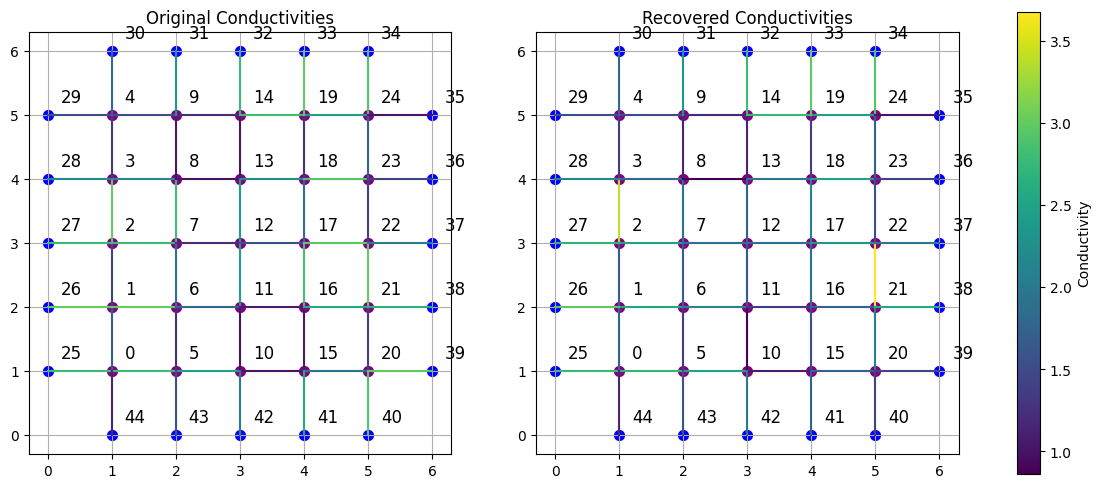



.........................................


.........................................


for n =  5
the batch size used for this training is  12
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.703421        1.817152       
(0,5)      2.778593        2.498751       
(0,25)     2.778593        2.774224       
(0,44)     1.145108        1.148194       
(1,2)      1.430035        1.755264       
(1,6)      2.999975        2.375096       
(1,26)     2.999975        2.937112       
(2,3)      2.998389        3.524611       
(2,7)      2.769652        2.353216       
(2,27)     2.769652        2.660904       
(3,4)      1.340625        1.346703       
(3,8)      2.191664        1.586756       
(3,28)     2.191664        2.183719       
(4,9)      1.527099        1.521218       
(4,29)     1.527099        1.527112       
(4,30)     1.813514        1.813673       
(5,6)      1.250992        1.287751       
(5,10)  

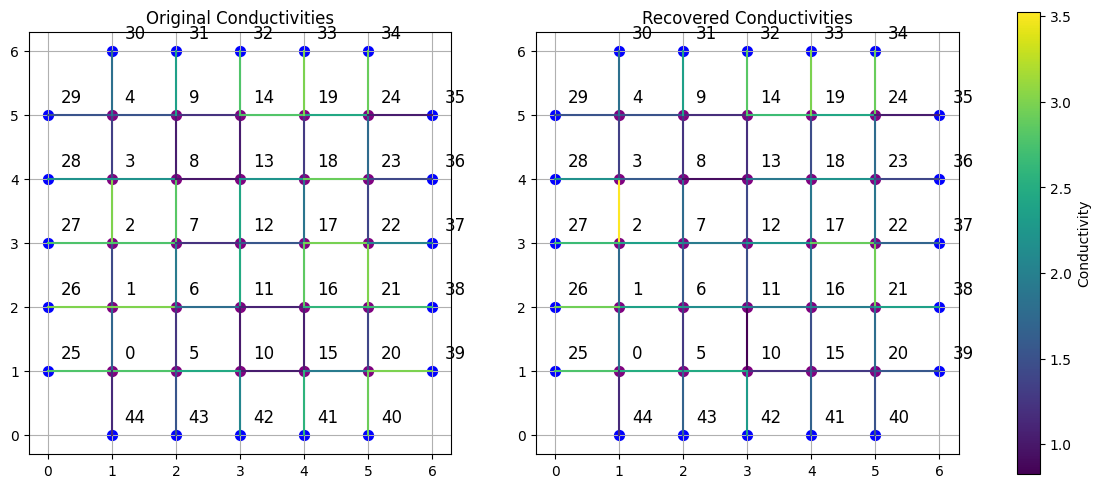



.........................................


.........................................


for n =  5
the batch size used for this training is  11
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.703421        1.826271       
(0,5)      2.778593        2.535168       
(0,25)     2.778593        2.762942       
(0,44)     1.145108        1.153205       
(1,2)      1.430035        1.744505       
(1,6)      2.999975        2.363692       
(1,26)     2.999975        2.941944       
(2,3)      2.998389        3.479901       
(2,7)      2.769652        2.357215       
(2,27)     2.769652        2.667240       
(3,4)      1.340625        1.340615       
(3,8)      2.191664        1.571561       
(3,28)     2.191664        2.189436       
(4,9)      1.527099        1.532641       
(4,29)     1.527099        1.527234       
(4,30)     1.813514        1.813301       
(5,6)      1.250992        1.255412       
(5,10)  

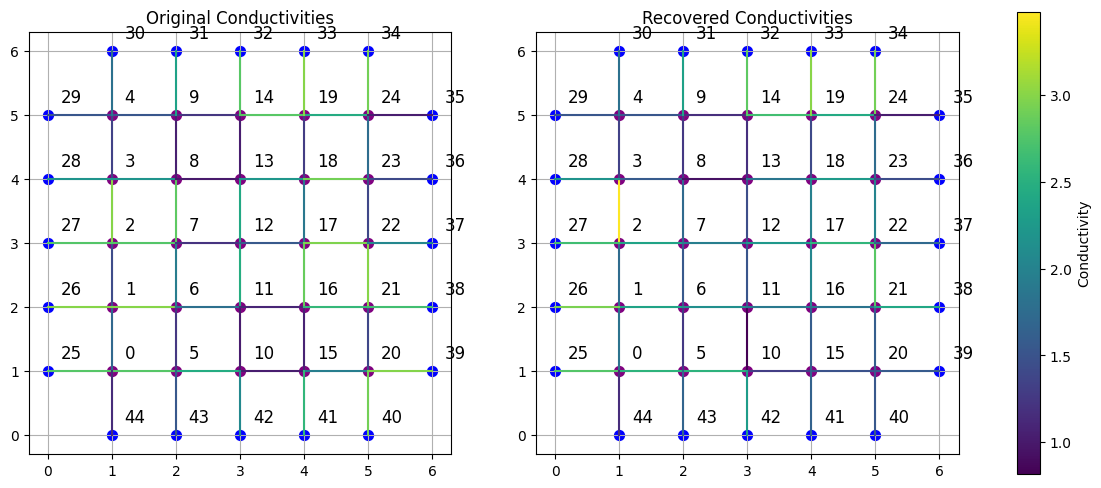



.........................................


.........................................


for n =  5
the batch size used for this training is  10
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.703421        1.811980       
(0,5)      2.778593        2.500572       
(0,25)     2.778593        2.773659       
(0,44)     1.145108        1.147971       
(1,2)      1.430035        1.740203       
(1,6)      2.999975        2.368474       
(1,26)     2.999975        2.945409       
(2,3)      2.998389        3.488734       
(2,7)      2.769652        2.365905       
(2,27)     2.769652        2.666671       
(3,4)      1.340625        1.345139       
(3,8)      2.191664        1.605537       
(3,28)     2.191664        2.186198       
(4,9)      1.527099        1.523459       
(4,29)     1.527099        1.526971       
(4,30)     1.813514        1.813505       
(5,6)      1.250992        1.269771       
(5,10)  

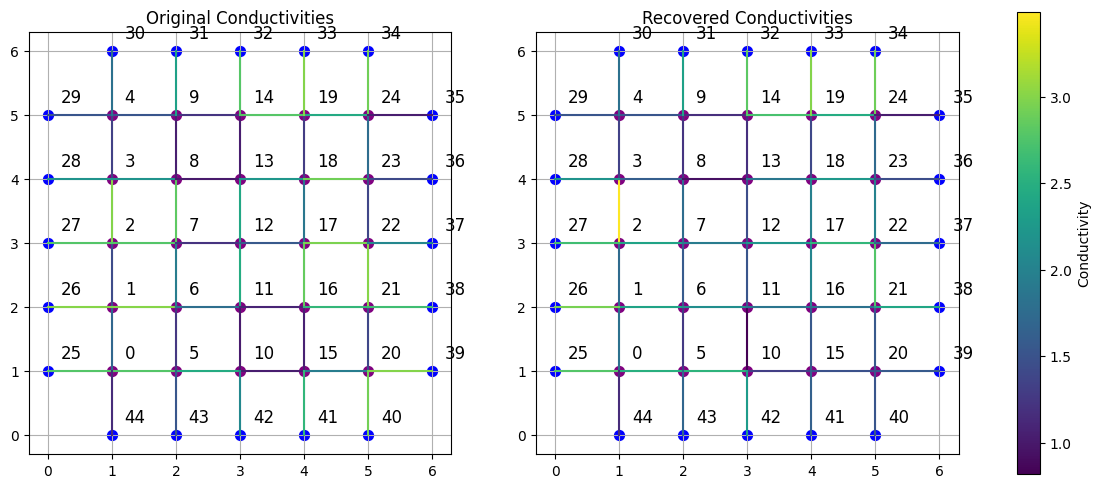



.........................................


.........................................


for n =  5
the batch size used for this training is  9
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.703421        1.819649       
(0,5)      2.778593        2.507804       
(0,25)     2.778593        2.771645       
(0,44)     1.145108        1.148978       
(1,2)      1.430035        1.664779       
(1,6)      2.999975        2.653206       
(1,26)     2.999975        2.934568       
(2,3)      2.998389        3.330564       
(2,7)      2.769652        2.316270       
(2,27)     2.769652        2.708260       
(3,4)      1.340625        1.347605       
(3,8)      2.191664        1.909887       
(3,28)     2.191664        2.178039       
(4,9)      1.527099        1.523867       
(4,29)     1.527099        1.527129       
(4,30)     1.813514        1.813866       
(5,6)      1.250992        1.192851       
(5,10)   

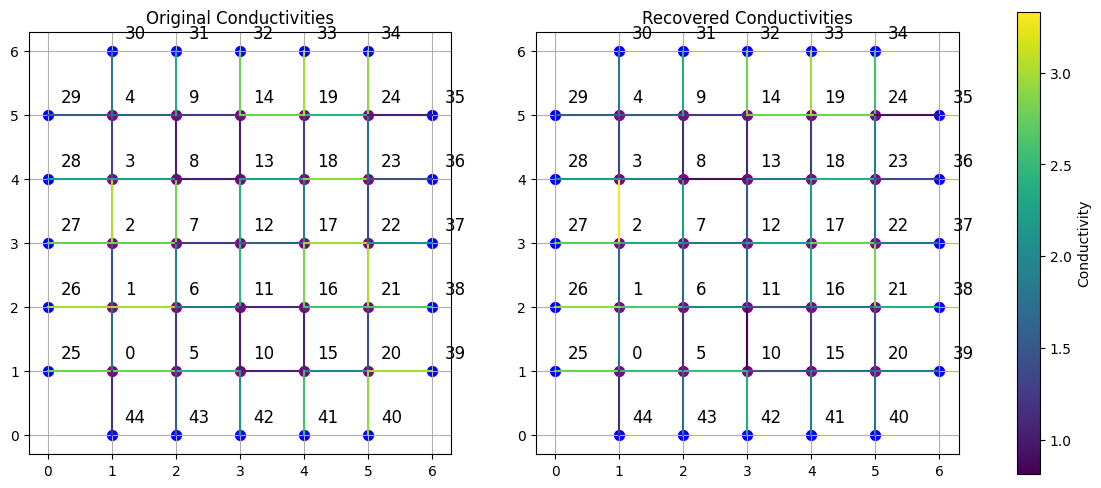



.........................................


.........................................


for n =  5
the batch size used for this training is  8
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.703421        1.811342       
(0,5)      2.778593        2.511765       
(0,25)     2.778593        2.768889       
(0,44)     1.145108        1.150443       
(1,2)      1.430035        1.677813       
(1,6)      2.999975        2.473527       
(1,26)     2.999975        2.949059       
(2,3)      2.998389        3.362062       
(2,7)      2.769652        2.321094       
(2,27)     2.769652        2.697319       
(3,4)      1.340625        1.339114       
(3,8)      2.191664        1.809740       
(3,28)     2.191664        2.184443       
(4,9)      1.527099        1.536402       
(4,29)     1.527099        1.527135       
(4,30)     1.813514        1.813484       
(5,6)      1.250992        1.274250       
(5,10)   

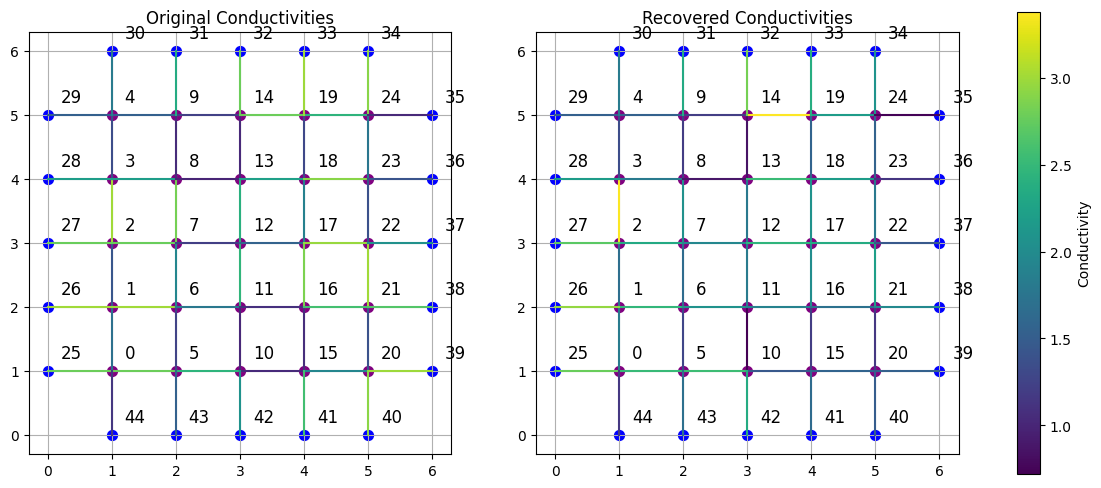



.........................................


.........................................


for n =  5
the batch size used for this training is  7
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.703421        1.747715       
(0,5)      2.778593        2.678735       
(0,25)     2.778593        2.778388       
(0,44)     1.145108        1.145696       
(1,2)      1.430035        1.523114       
(1,6)      2.999975        2.883888       
(1,26)     2.999975        2.969448       
(2,3)      2.998389        3.199894       
(2,7)      2.769652        2.630890       
(2,27)     2.769652        2.722942       
(3,4)      1.340625        1.320770       
(3,8)      2.191664        1.716551       
(3,28)     2.191664        2.207302       
(4,9)      1.527099        1.559024       
(4,29)     1.527099        1.527252       
(4,30)     1.813514        1.813486       
(5,6)      1.250992        1.206617       
(5,10)   

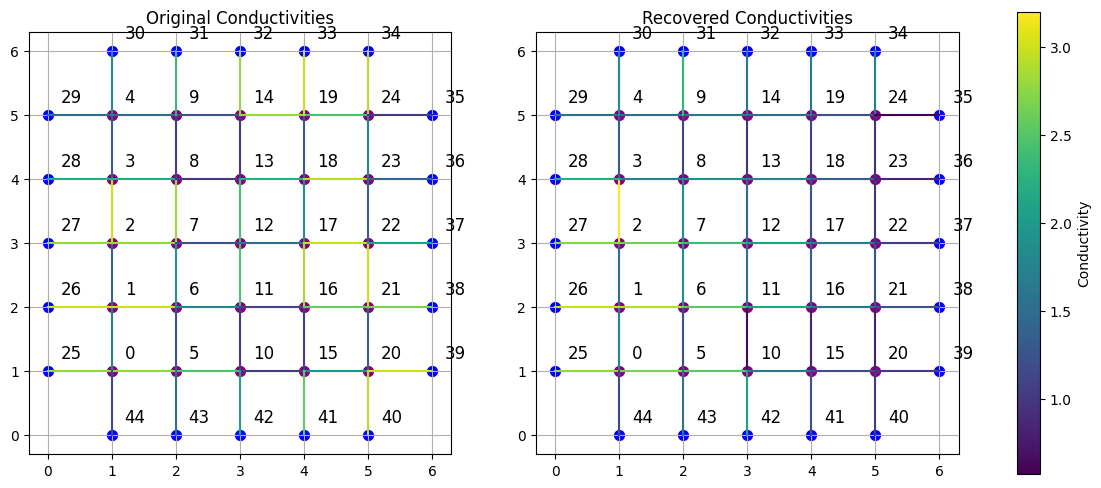



.........................................


.........................................


for n =  5
the batch size used for this training is  6
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.703421        1.723832       
(0,5)      2.778593        2.753925       
(0,25)     2.778593        2.769740       
(0,44)     1.145108        1.149619       
(1,2)      1.430035        1.499159       
(1,6)      2.999975        2.696929       
(1,26)     2.999975        3.002509       
(2,3)      2.998389        3.207861       
(2,7)      2.769652        2.471696       
(2,27)     2.769652        2.735616       
(3,4)      1.340625        1.321441       
(3,8)      2.191664        1.833237       
(3,28)     2.191664        2.195130       
(4,9)      1.527099        1.590003       
(4,29)     1.527099        1.527190       
(4,30)     1.813514        1.813273       
(5,6)      1.250992        1.264947       
(5,10)   

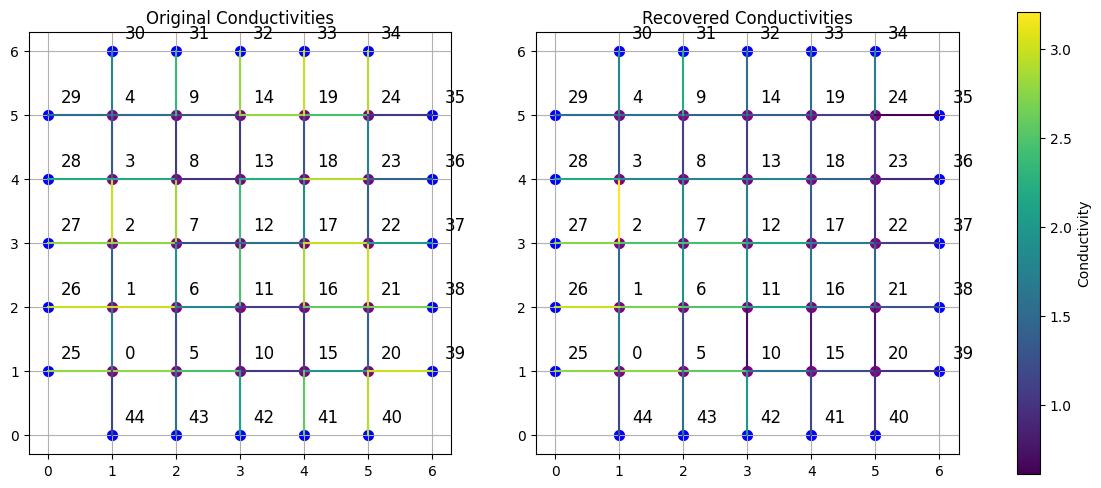



.........................................


.........................................


for n =  5
the batch size used for this training is  5
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.703421        1.724299       
(0,5)      2.778593        2.719738       
(0,25)     2.778593        2.773844       
(0,44)     1.145108        1.147422       
(1,2)      1.430035        1.512542       
(1,6)      2.999975        2.654209       
(1,26)     2.999975        3.002440       
(2,3)      2.998389        3.212868       
(2,7)      2.769652        2.432466       
(2,27)     2.769652        2.732819       
(3,4)      1.340625        1.318603       
(3,8)      2.191664        1.758772       
(3,28)     2.191664        2.199258       
(4,9)      1.527099        1.591188       
(4,29)     1.527099        1.527264       
(4,30)     1.813514        1.812334       
(5,6)      1.250992        1.264552       
(5,10)   

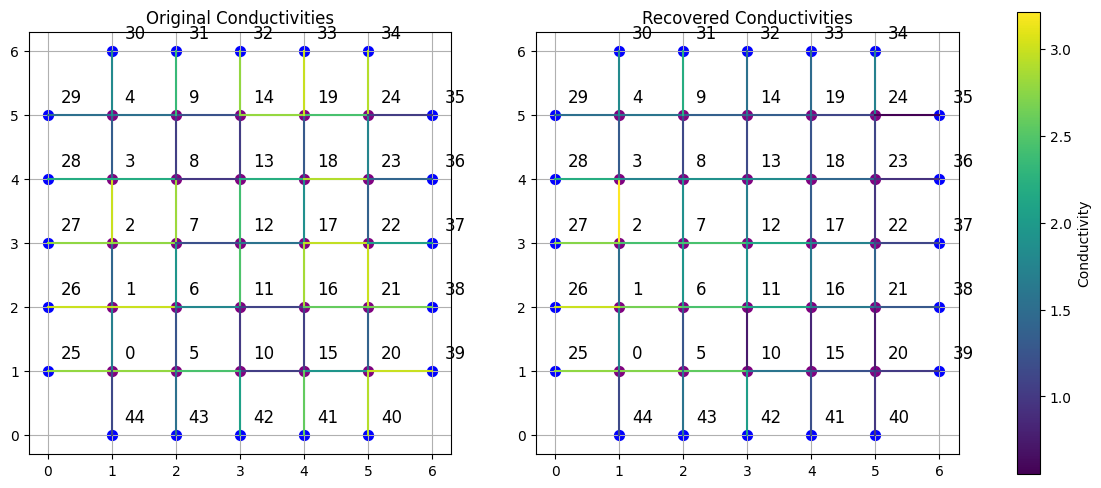



.........................................


.........................................


for n =  5
the batch size used for this training is  4
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.703421        1.735346       
(0,5)      2.778593        2.709263       
(0,25)     2.778593        2.774019       
(0,44)     1.145108        1.147632       
(1,2)      1.430035        1.514800       
(1,6)      2.999975        2.723885       
(1,26)     2.999975        2.988020       
(2,3)      2.998389        3.359103       
(2,7)      2.769652        2.322174       
(2,27)     2.769652        2.731917       
(3,4)      1.340625        2.204871       
(3,8)      2.191664        1.780703       
(3,28)     2.191664        2.162042       
(4,9)      1.527099        1.016594       
(4,29)     1.527099        0.793679       
(4,30)     1.813514        0.942933       
(5,6)      1.250992        1.256750       
(5,10)   

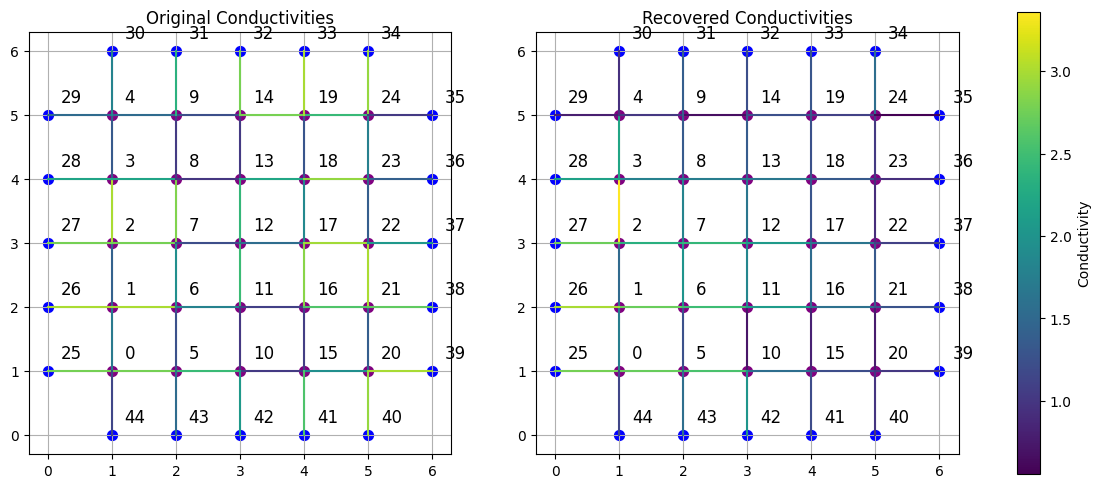



.........................................


.........................................


for n =  5
the batch size used for this training is  3
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.703421        1.706168       
(0,5)      2.778593        2.804999       
(0,25)     2.778593        2.772595       
(0,44)     1.145108        1.148349       
(1,2)      1.430035        1.557960       
(1,6)      2.999975        2.718614       
(1,26)     2.999975        3.002579       
(2,3)      2.998389        3.764253       
(2,7)      2.769652        2.924489       
(2,27)     2.769652        2.672429       
(3,4)      1.340625        2.115379       
(3,8)      2.191664        1.068395       
(3,28)     2.191664        1.997266       
(4,9)      1.527099        1.130758       
(4,29)     1.527099        0.709158       
(4,30)     1.813514        0.843411       
(5,6)      1.250992        1.271915       
(5,10)   

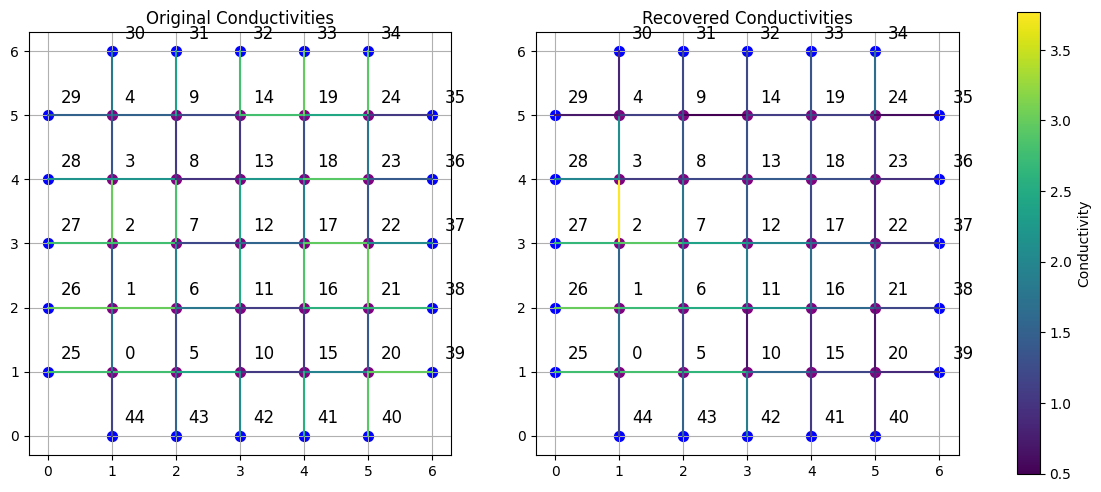



.........................................


.........................................


for n =  5
the batch size used for this training is  2
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      1.703421        1.791273       
(0,5)      2.778593        2.951880       
(0,25)     2.778593        2.775437       
(0,44)     1.145108        1.146943       
(1,2)      1.430035        3.468504       
(1,6)      2.999975        3.226971       
(1,26)     2.999975        2.849847       
(2,3)      2.998389        1.972056       
(2,7)      2.769652        1.233278       
(2,27)     2.769652        1.359952       
(3,4)      1.340625        1.182338       
(3,8)      2.191664        0.575654       
(3,28)     2.191664        1.058219       
(4,9)      1.527099        0.494013       
(4,29)     1.527099        0.381048       
(4,30)     1.813514        0.452704       
(5,6)      1.250992        1.227066       
(5,10)   

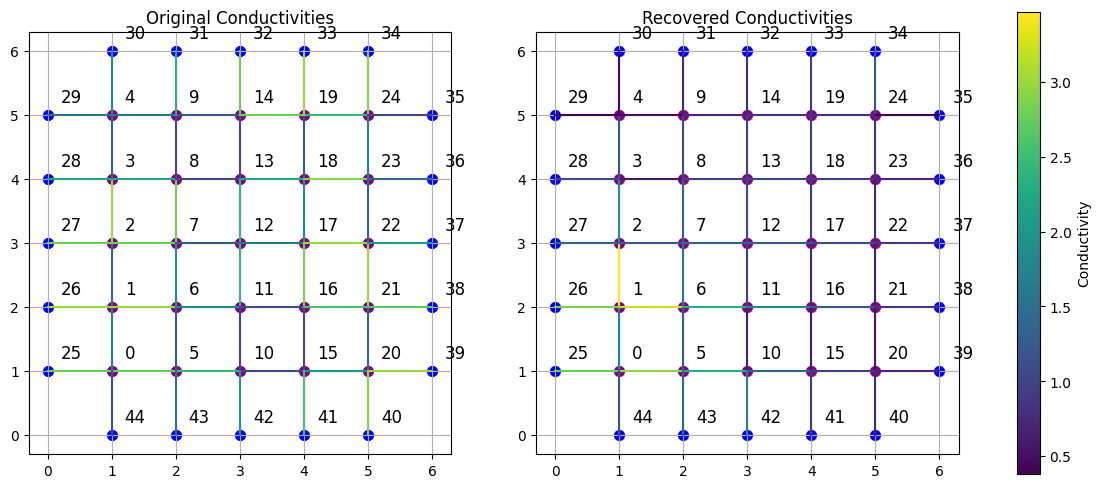



.........................................




In [15]:

run_demo_batch(5)

.........................................


for n =  6
the batch size used for this training is  24
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.478216       
(0,6)      2.701984        2.658886       
(0,36)     2.701984        2.700806       
(0,59)     1.145108        1.145701       
(1,2)      1.011633        1.168181       
(1,7)      2.975587        2.646241       
(1,37)     2.975587        2.953730       
(2,3)      2.137771        2.804467       
(2,8)      2.939448        2.483616       
(2,38)     2.939448        2.783434       
(3,4)      2.909341        3.353001       
(3,9)      2.605040        2.020200       
(3,39)     2.605040        2.518952       
(4,5)      1.340625        1.346521       
(4,10)     2.078537        1.415895       
(4,40)     2.078537        2.078038       
(5,11)     1.527099        1.508837       
(5,41)     1.527099        1.527068       
(5,42)     

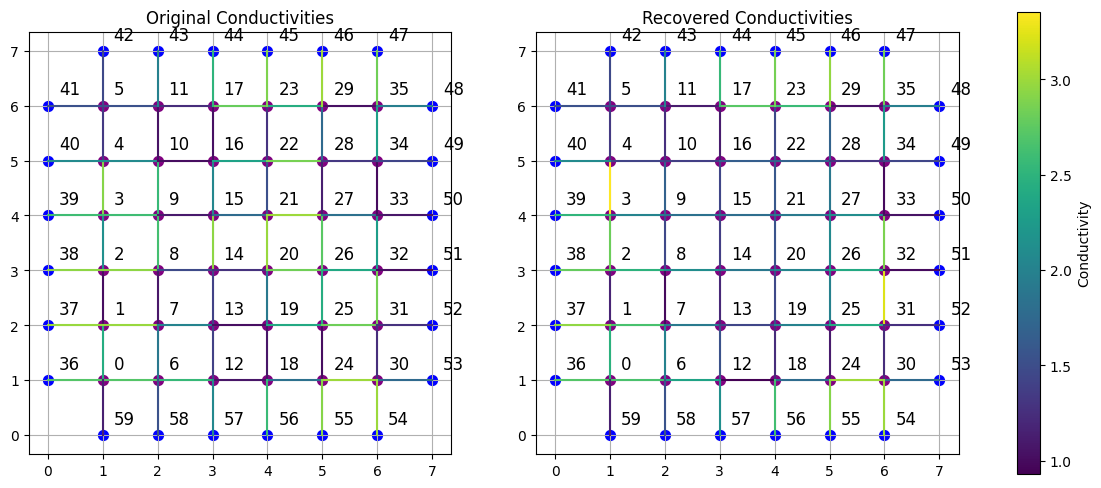



.........................................


.........................................


for n =  6
the batch size used for this training is  23
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.476020       
(0,6)      2.701984        2.690695       
(0,36)     2.701984        2.698326       
(0,59)     1.145108        1.146700       
(1,2)      1.011633        1.167943       
(1,7)      2.975587        2.651557       
(1,37)     2.975587        2.949291       
(2,3)      2.137771        2.778678       
(2,8)      2.939448        2.396973       
(2,38)     2.939448        2.792278       
(3,4)      2.909341        3.300059       
(3,9)      2.605040        1.924399       
(3,39)     2.605040        2.529086       
(4,5)      1.340625        1.344231       
(4,10)     2.078537        1.407363       
(4,40)     2.078537        2.083960       
(5,11)     1.527099        1.523582       
(5,41)  

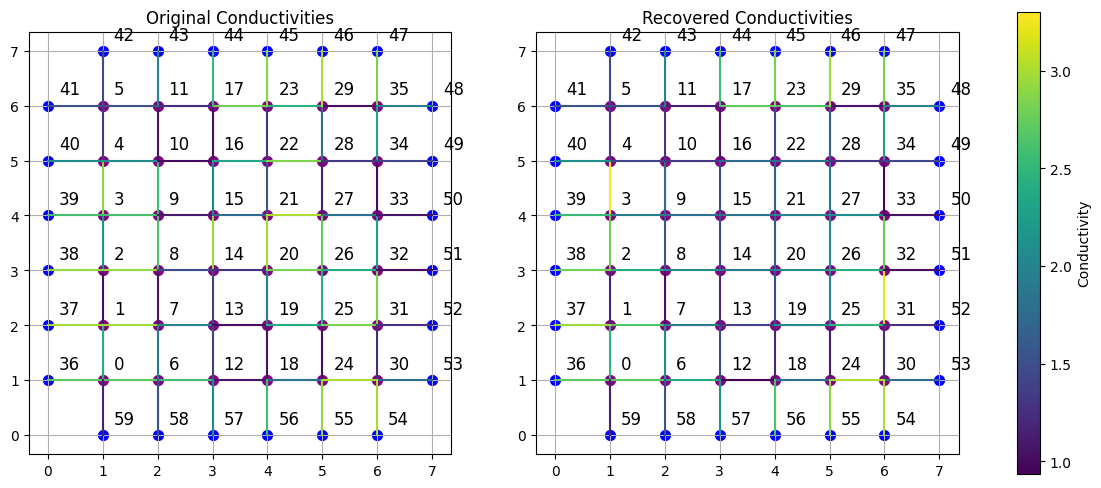



.........................................


.........................................


for n =  6
the batch size used for this training is  22
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.470532       
(0,6)      2.701984        2.688291       
(0,36)     2.701984        2.700294       
(0,59)     1.145108        1.146357       
(1,2)      1.011633        1.168269       
(1,7)      2.975587        2.657170       
(1,37)     2.975587        2.956342       
(2,3)      2.137771        2.793306       
(2,8)      2.939448        2.451085       
(2,38)     2.939448        2.785867       
(3,4)      2.909341        3.329760       
(3,9)      2.605040        1.957248       
(3,39)     2.605040        2.524742       
(4,5)      1.340625        1.336443       
(4,10)     2.078537        1.394267       
(4,40)     2.078537        2.082850       
(5,11)     1.527099        1.533808       
(5,41)  

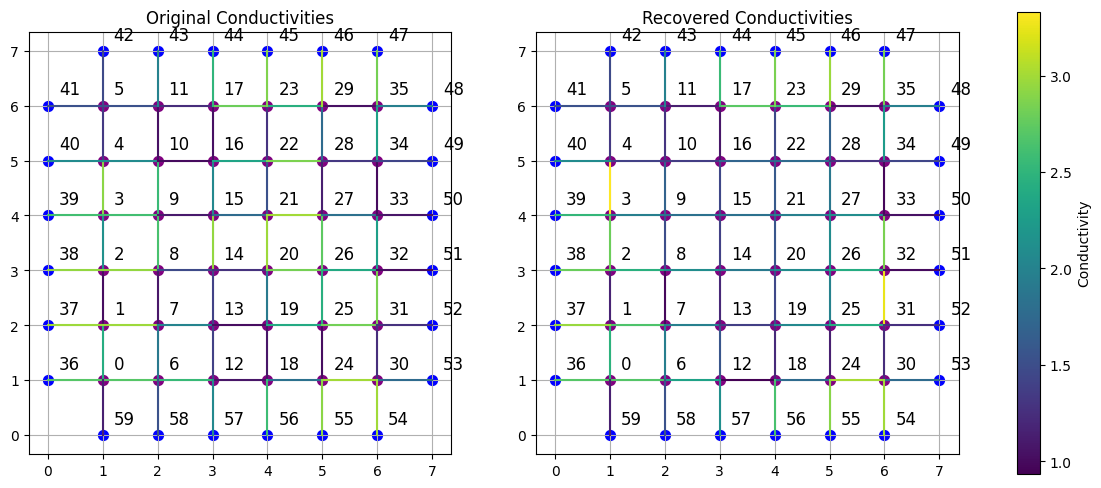



.........................................


.........................................


for n =  6
the batch size used for this training is  21
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.543793       
(0,6)      2.701984        2.448920       
(0,36)     2.701984        2.710265       
(0,59)     1.145108        1.142648       
(1,2)      1.011633        1.186955       
(1,7)      2.975587        2.654067       
(1,37)     2.975587        2.929726       
(2,3)      2.137771        2.818910       
(2,8)      2.939448        2.401963       
(2,38)     2.939448        2.777771       
(3,4)      2.909341        3.310706       
(3,9)      2.605040        1.875586       
(3,39)     2.605040        2.527924       
(4,5)      1.340625        1.341215       
(4,10)     2.078537        1.387769       
(4,40)     2.078537        2.084333       
(5,11)     1.527099        1.541969       
(5,41)  

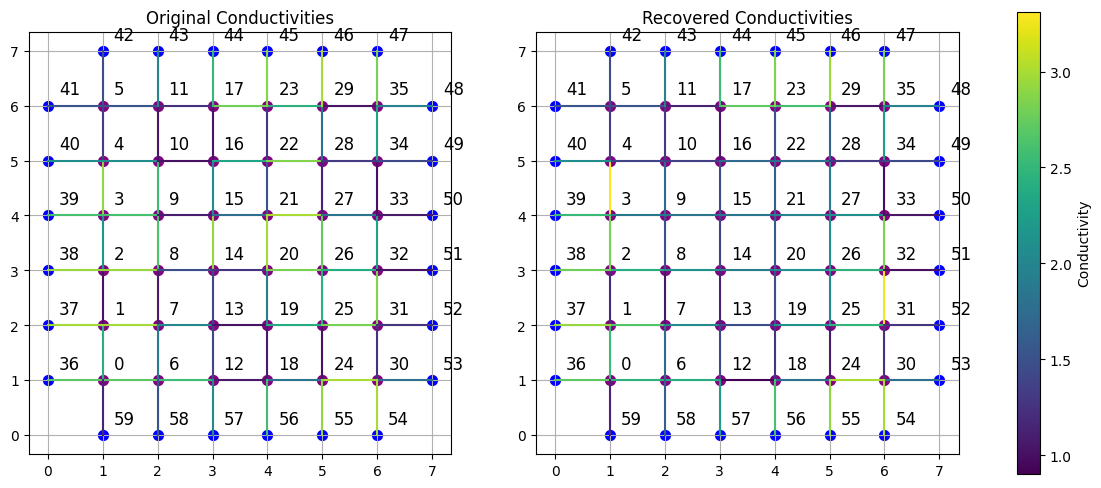



.........................................


.........................................


for n =  6
the batch size used for this training is  20
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.612357       
(0,6)      2.701984        2.448574       
(0,36)     2.701984        2.695810       
(0,59)     1.145108        1.148660       
(1,2)      1.011633        1.211001       
(1,7)      2.975587        2.606462       
(1,37)     2.975587        2.903970       
(2,3)      2.137771        2.771586       
(2,8)      2.939448        2.181628       
(2,38)     2.939448        2.801763       
(3,4)      2.909341        3.354559       
(3,9)      2.605040        1.813069       
(3,39)     2.605040        2.530864       
(4,5)      1.340625        1.351322       
(4,10)     2.078537        1.489459       
(4,40)     2.078537        2.069553       
(5,11)     1.527099        1.524977       
(5,41)  

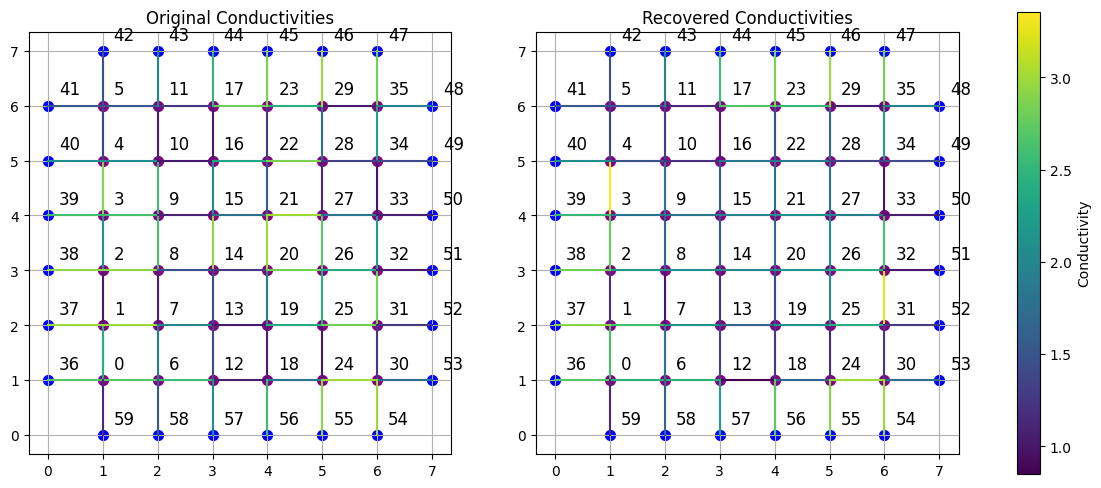



.........................................


.........................................


for n =  6
the batch size used for this training is  19
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.594971       
(0,6)      2.701984        2.309953       
(0,36)     2.701984        2.716145       
(0,59)     1.145108        1.139200       
(1,2)      1.011633        1.199004       
(1,7)      2.975587        2.648613       
(1,37)     2.975587        2.904438       
(2,3)      2.137771        2.850132       
(2,8)      2.939448        2.383054       
(2,38)     2.939448        2.768416       
(3,4)      2.909341        3.330610       
(3,9)      2.605040        1.860838       
(3,39)     2.605040        2.523681       
(4,5)      1.340625        1.342330       
(4,10)     2.078537        1.372138       
(4,40)     2.078537        2.083467       
(5,11)     1.527099        1.531535       
(5,41)  

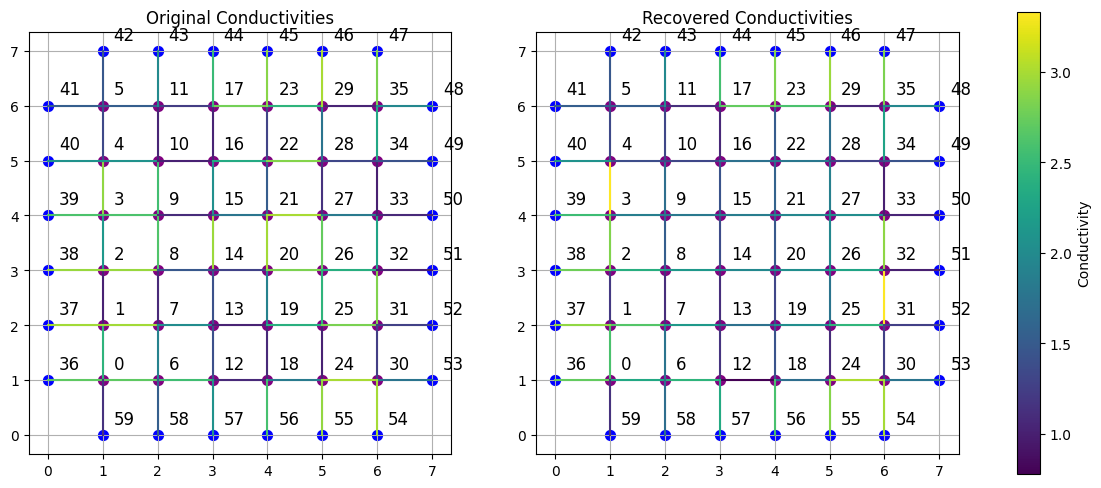



.........................................


.........................................


for n =  6
the batch size used for this training is  18
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.593548       
(0,6)      2.701984        2.420217       
(0,36)     2.701984        2.701419       
(0,59)     1.145108        1.146592       
(1,2)      1.011633        1.194755       
(1,7)      2.975587        2.662051       
(1,37)     2.975587        2.900157       
(2,3)      2.137771        2.672694       
(2,8)      2.939448        2.046521       
(2,38)     2.939448        2.840730       
(3,4)      2.909341        3.334073       
(3,9)      2.605040        1.792786       
(3,39)     2.605040        2.542317       
(4,5)      1.340625        1.359241       
(4,10)     2.078537        1.602616       
(4,40)     2.078537        2.062634       
(5,11)     1.527099        1.517872       
(5,41)  

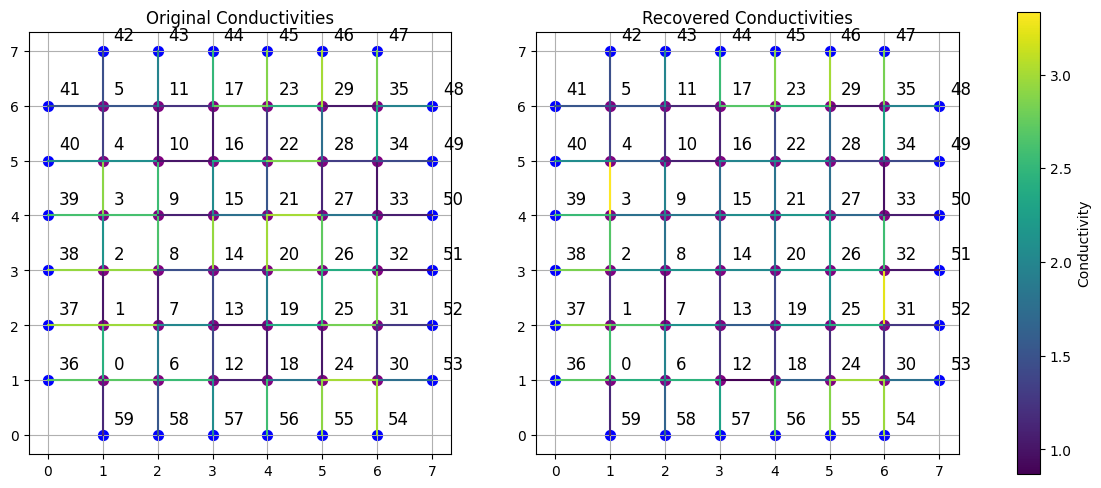



.........................................


.........................................


for n =  6
the batch size used for this training is  17
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.665319       
(0,6)      2.701984        2.295848       
(0,36)     2.701984        2.702515       
(0,59)     1.145108        1.145878       
(1,2)      1.011633        1.191112       
(1,7)      2.975587        2.736896       
(1,37)     2.975587        2.881818       
(2,3)      2.137771        2.769693       
(2,8)      2.939448        2.308968       
(2,38)     2.939448        2.795344       
(3,4)      2.909341        3.318993       
(3,9)      2.605040        1.794537       
(3,39)     2.605040        2.536298       
(4,5)      1.340625        1.347334       
(4,10)     2.078537        1.444700       
(4,40)     2.078537        2.076508       
(5,11)     1.527099        1.520752       
(5,41)  

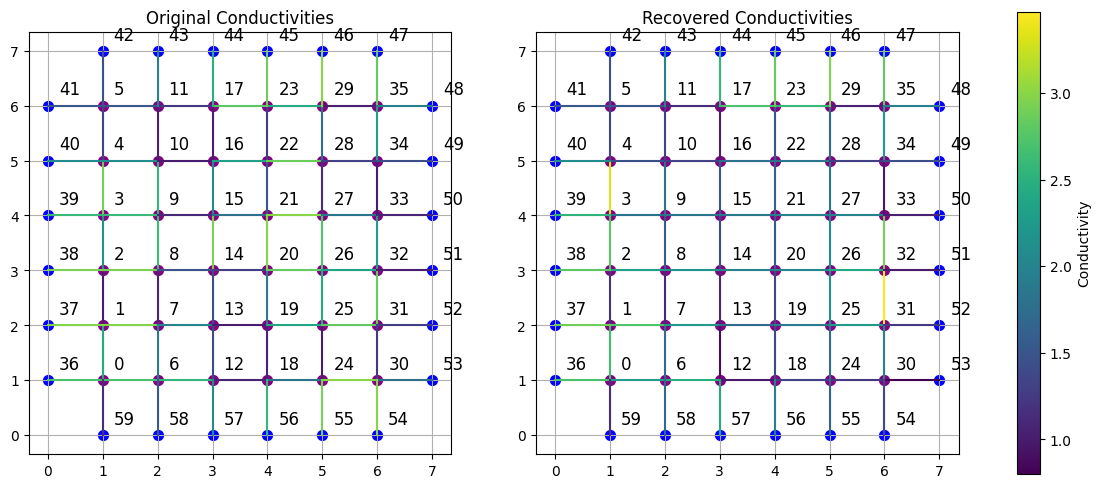



.........................................


.........................................


for n =  6
the batch size used for this training is  16
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.658517       
(0,6)      2.701984        2.274039       
(0,36)     2.701984        2.705581       
(0,59)     1.145108        1.144772       
(1,2)      1.011633        1.178386       
(1,7)      2.975587        2.764457       
(1,37)     2.975587        2.886368       
(2,3)      2.137771        2.774970       
(2,8)      2.939448        2.323224       
(2,38)     2.939448        2.795563       
(3,4)      2.909341        3.286712       
(3,9)      2.605040        1.780807       
(3,39)     2.605040        2.538428       
(4,5)      1.340625        1.343524       
(4,10)     2.078537        1.431194       
(4,40)     2.078537        2.081393       
(5,11)     1.527099        1.519977       
(5,41)  

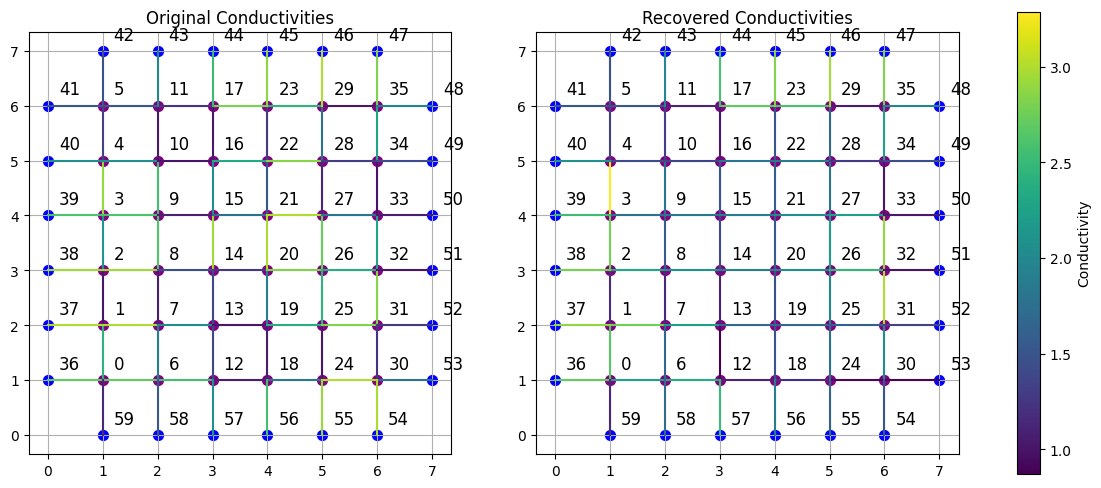



.........................................


.........................................


for n =  6
the batch size used for this training is  15
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.613521       
(0,6)      2.701984        2.326553       
(0,36)     2.701984        2.710438       
(0,59)     1.145108        1.142011       
(1,2)      1.011633        1.202320       
(1,7)      2.975587        2.741855       
(1,37)     2.975587        2.891025       
(2,3)      2.137771        2.730494       
(2,8)      2.939448        2.205669       
(2,38)     2.939448        2.814626       
(3,4)      2.909341        3.344173       
(3,9)      2.605040        1.876494       
(3,39)     2.605040        2.533747       
(4,5)      1.340625        1.362917       
(4,10)     2.078537        1.553878       
(4,40)     2.078537        2.066160       
(5,11)     1.527099        1.509435       
(5,41)  

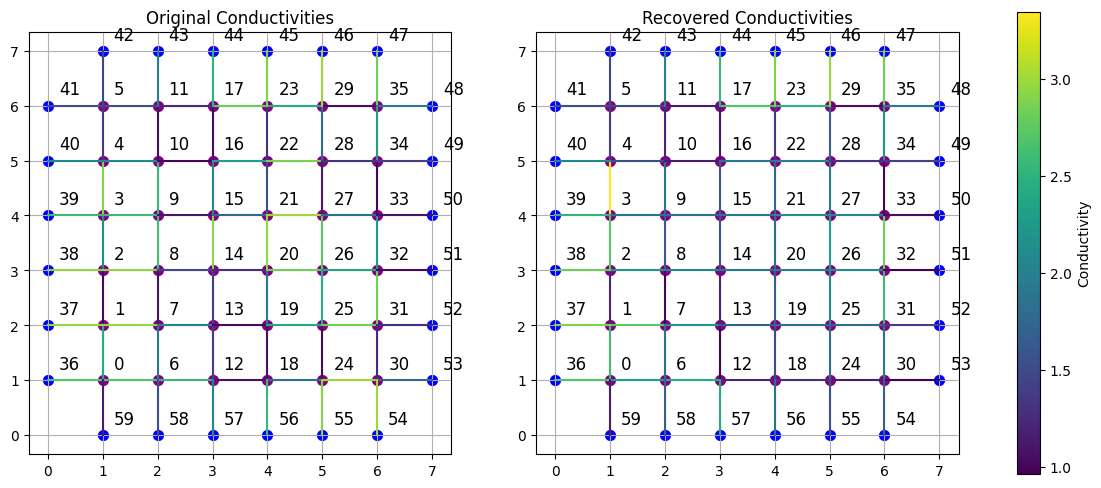



.........................................


.........................................


for n =  6
the batch size used for this training is  14
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.609399       
(0,6)      2.701984        2.325579       
(0,36)     2.701984        2.707102       
(0,59)     1.145108        1.144008       
(1,2)      1.011633        1.196268       
(1,7)      2.975587        2.653374       
(1,37)     2.975587        2.903118       
(2,3)      2.137771        2.726018       
(2,8)      2.939448        2.211825       
(2,38)     2.939448        2.814124       
(3,4)      2.909341        3.315991       
(3,9)      2.605040        1.899137       
(3,39)     2.605040        2.534846       
(4,5)      1.340625        1.350521       
(4,10)     2.078537        1.564376       
(4,40)     2.078537        2.070223       
(5,11)     1.527099        1.523932       
(5,41)  

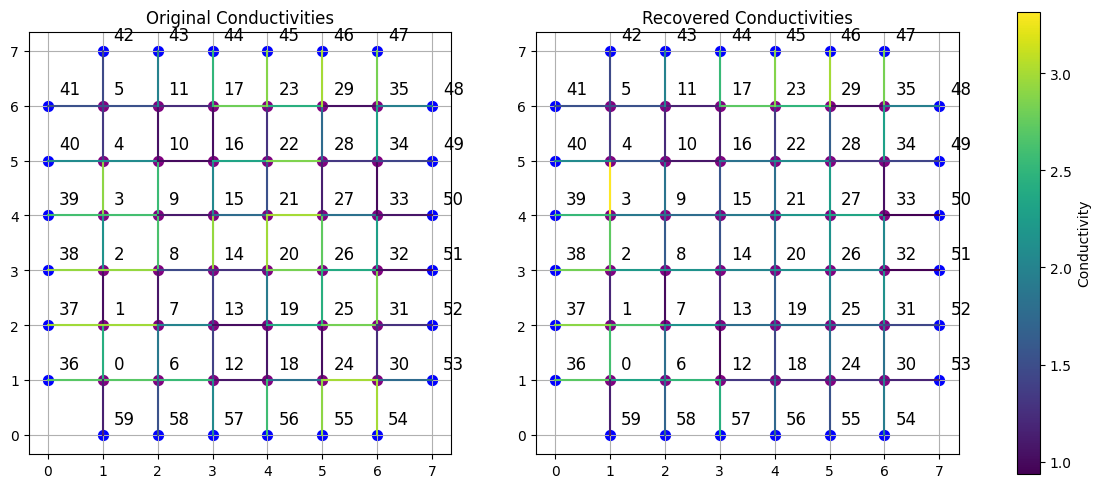



.........................................


.........................................


for n =  6
the batch size used for this training is  13
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.581436       
(0,6)      2.701984        2.429743       
(0,36)     2.701984        2.699792       
(0,59)     1.145108        1.146252       
(1,2)      1.011633        1.169372       
(1,7)      2.975587        2.674522       
(1,37)     2.975587        2.915662       
(2,3)      2.137771        2.717412       
(2,8)      2.939448        2.268857       
(2,38)     2.939448        2.815890       
(3,4)      2.909341        3.320353       
(3,9)      2.605040        1.908122       
(3,39)     2.605040        2.534401       
(4,5)      1.340625        1.344555       
(4,10)     2.078537        1.538927       
(4,40)     2.078537        2.072630       
(5,11)     1.527099        1.530960       
(5,41)  

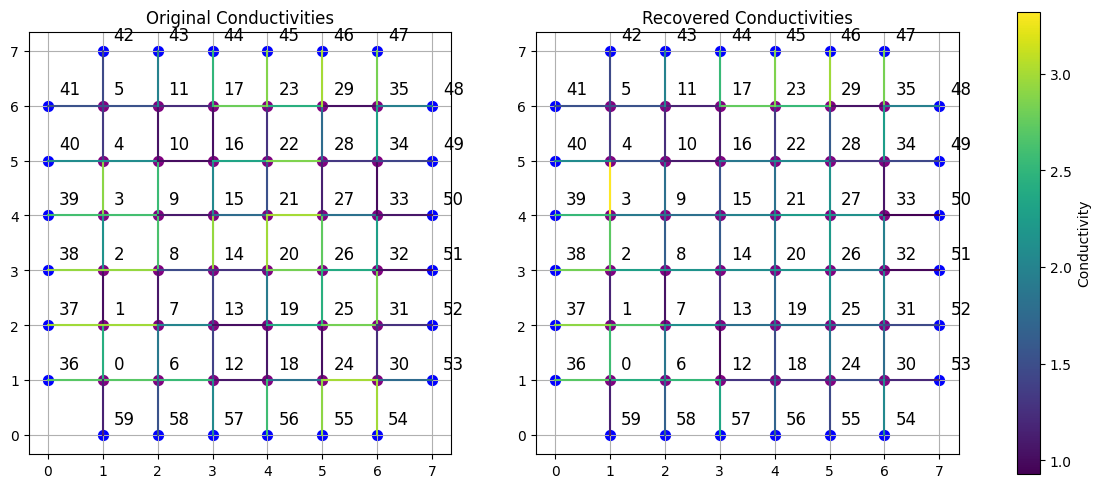



.........................................


.........................................


for n =  6
the batch size used for this training is  12
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.581110       
(0,6)      2.701984        2.397070       
(0,36)     2.701984        2.704009       
(0,59)     1.145108        1.144346       
(1,2)      1.011633        1.191952       
(1,7)      2.975587        2.652632       
(1,37)     2.975587        2.912947       
(2,3)      2.137771        2.705425       
(2,8)      2.939448        2.199141       
(2,38)     2.939448        2.822807       
(3,4)      2.909341        3.324383       
(3,9)      2.605040        1.927189       
(3,39)     2.605040        2.534189       
(4,5)      1.340625        1.351633       
(4,10)     2.078537        1.578595       
(4,40)     2.078537        2.068644       
(5,11)     1.527099        1.519614       
(5,41)  

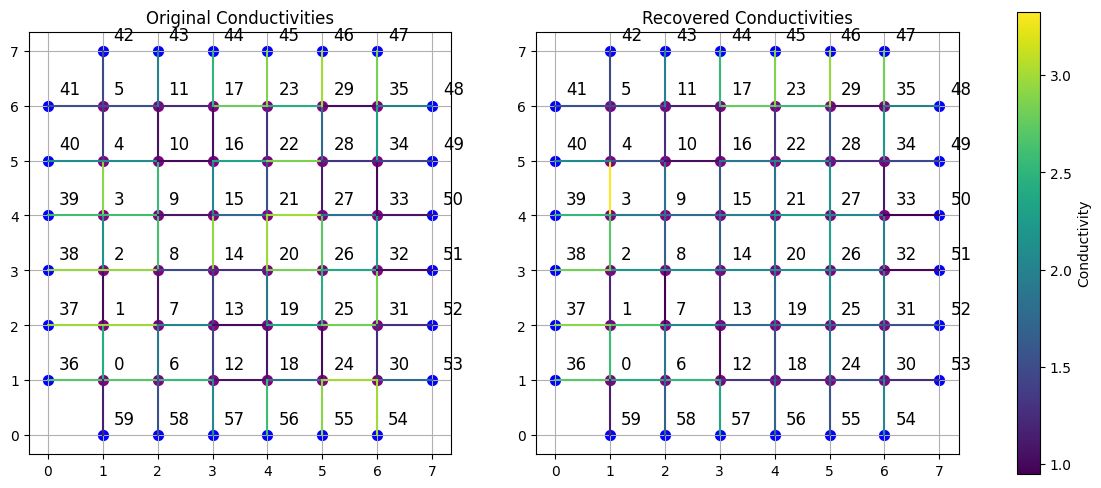



.........................................


.........................................


for n =  6
the batch size used for this training is  11
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.604781       
(0,6)      2.701984        2.415182       
(0,36)     2.701984        2.698129       
(0,59)     1.145108        1.148023       
(1,2)      1.011633        1.213014       
(1,7)      2.975587        2.629419       
(1,37)     2.975587        2.904581       
(2,3)      2.137771        2.702252       
(2,8)      2.939448        2.127145       
(2,38)     2.939448        2.825461       
(3,4)      2.909341        3.330464       
(3,9)      2.605040        1.939952       
(3,39)     2.605040        2.532859       
(4,5)      1.340625        1.350897       
(4,10)     2.078537        1.621476       
(4,40)     2.078537        2.066122       
(5,11)     1.527099        1.523867       
(5,41)  

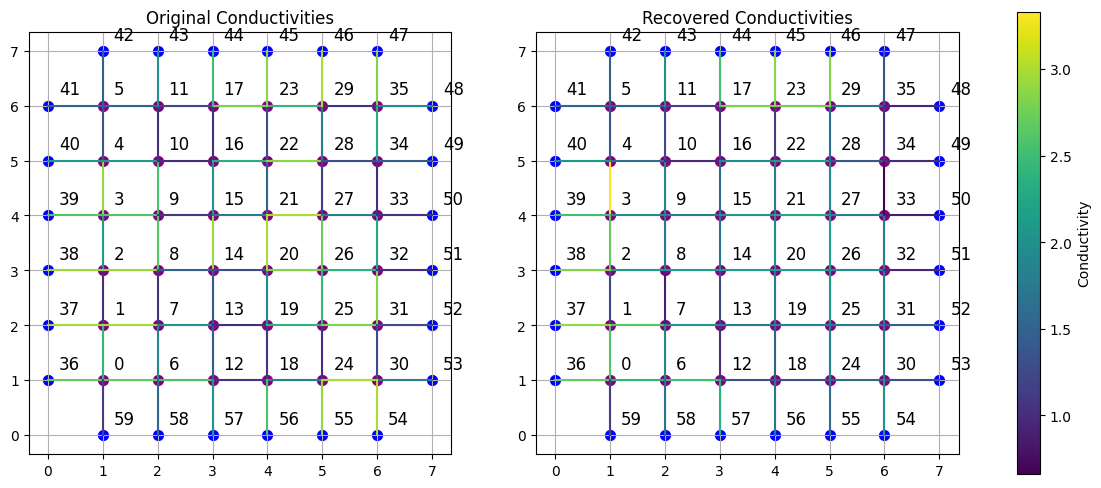



.........................................


.........................................


for n =  6
the batch size used for this training is  10
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.568939       
(0,6)      2.701984        2.415002       
(0,36)     2.701984        2.704649       
(0,59)     1.145108        1.143704       
(1,2)      1.011633        1.204438       
(1,7)      2.975587        2.637788       
(1,37)     2.975587        2.912061       
(2,3)      2.137771        2.662908       
(2,8)      2.939448        2.085443       
(2,38)     2.939448        2.839571       
(3,4)      2.909341        3.301329       
(3,9)      2.605040        1.958266       
(3,39)     2.605040        2.536532       
(4,5)      1.340625        1.349949       
(4,10)     2.078537        1.630169       
(4,40)     2.078537        2.068619       
(5,11)     1.527099        1.521601       
(5,41)  

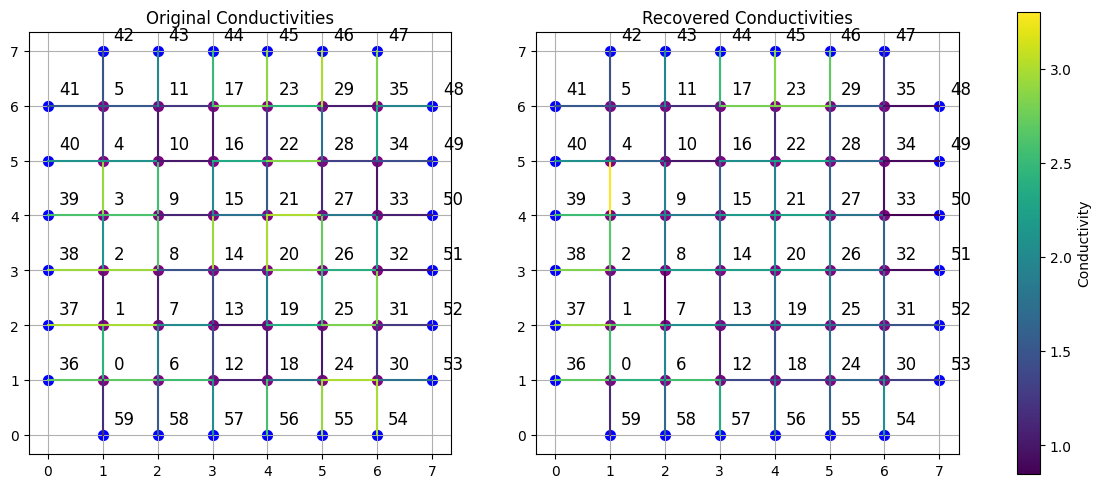



.........................................


.........................................


for n =  6
the batch size used for this training is  9
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.574411       
(0,6)      2.701984        2.476222       
(0,36)     2.701984        2.699053       
(0,59)     1.145108        1.146168       
(1,2)      1.011633        1.163749       
(1,7)      2.975587        2.746538       
(1,37)     2.975587        2.910010       
(2,3)      2.137771        2.565870       
(2,8)      2.939448        2.152938       
(2,38)     2.939448        2.863800       
(3,4)      2.909341        3.222279       
(3,9)      2.605040        1.981527       
(3,39)     2.605040        2.550626       
(4,5)      1.340625        1.344615       
(4,10)     2.078537        1.631295       
(4,40)     2.078537        2.076801       
(5,11)     1.527099        1.524732       
(5,41)   

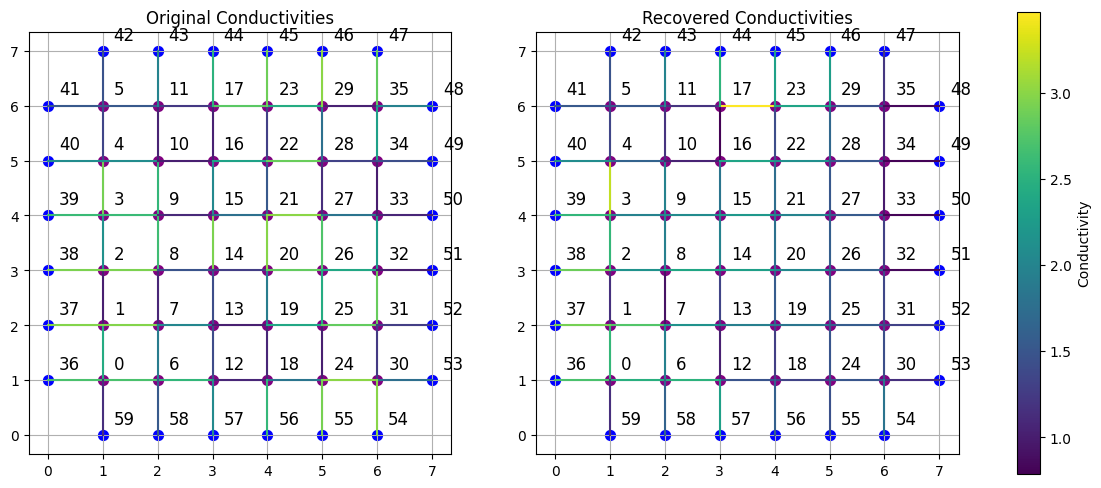



.........................................


.........................................


for n =  6
the batch size used for this training is  8
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.559876       
(0,6)      2.701984        2.520437       
(0,36)     2.701984        2.699366       
(0,59)     1.145108        1.147009       
(1,2)      1.011633        1.103674       
(1,7)      2.975587        3.027338       
(1,37)     2.975587        2.913819       
(2,3)      2.137771        2.414104       
(2,8)      2.939448        2.506290       
(2,38)     2.939448        2.888735       
(3,4)      2.909341        3.125558       
(3,9)      2.605040        2.206550       
(3,39)     2.605040        2.570189       
(4,5)      1.340625        1.352422       
(4,10)     2.078537        1.846988       
(4,40)     2.078537        2.070644       
(5,11)     1.527099        1.509936       
(5,41)   

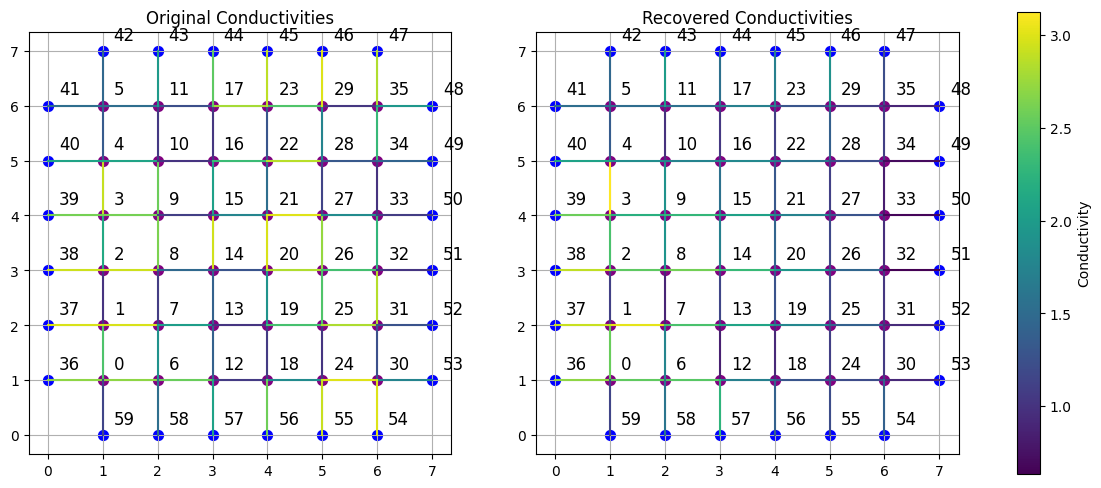



.........................................


.........................................


for n =  6
the batch size used for this training is  7
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.537270       
(0,6)      2.701984        2.548496       
(0,36)     2.701984        2.698860       
(0,59)     1.145108        1.147355       
(1,2)      1.011633        1.072315       
(1,7)      2.975587        3.006427       
(1,37)     2.975587        2.929271       
(2,3)      2.137771        2.410861       
(2,8)      2.939448        2.574954       
(2,38)     2.939448        2.892226       
(3,4)      2.909341        3.079637       
(3,9)      2.605040        2.299755       
(3,39)     2.605040        2.565681       
(4,5)      1.340625        1.292095       
(4,10)     2.078537        1.734225       
(4,40)     2.078537        2.090410       
(5,11)     1.527099        1.663660       
(5,41)   

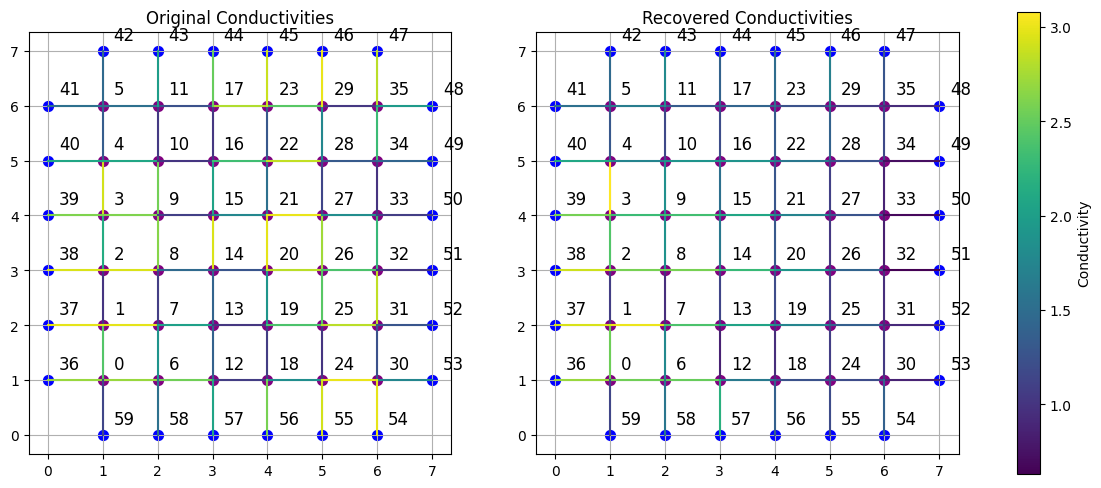



.........................................


.........................................


for n =  6
the batch size used for this training is  6
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.522321       
(0,6)      2.701984        2.495586       
(0,36)     2.701984        2.706612       
(0,59)     1.145108        1.143438       
(1,2)      1.011633        1.051320       
(1,7)      2.975587        2.993437       
(1,37)     2.975587        2.936781       
(2,3)      2.137771        2.460054       
(2,8)      2.939448        2.695650       
(2,38)     2.939448        2.867936       
(3,4)      2.909341        3.113064       
(3,9)      2.605040        2.176003       
(3,39)     2.605040        2.565868       
(4,5)      1.340625        1.309464       
(4,10)     2.078537        1.669323       
(4,40)     2.078537        2.088073       
(5,11)     1.527099        1.616983       
(5,41)   

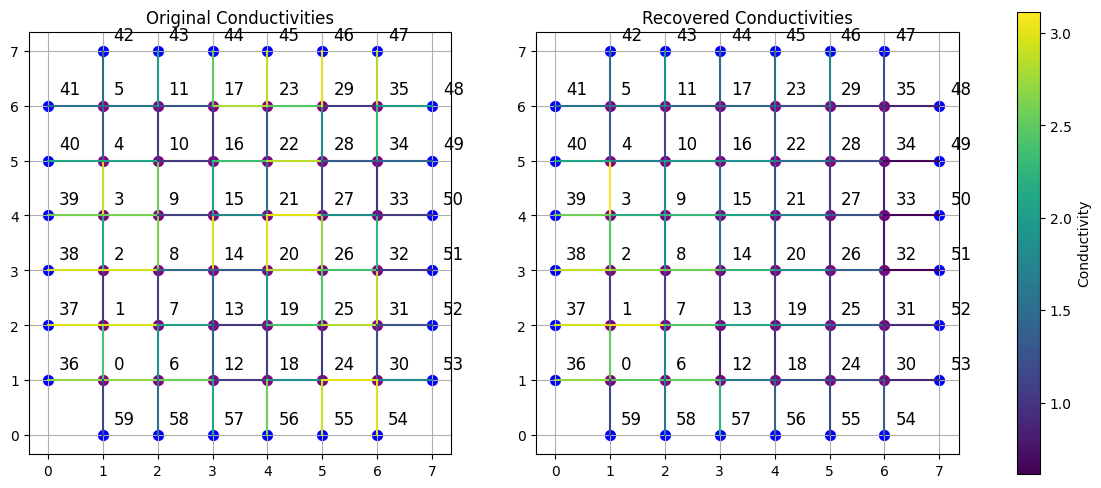



.........................................


.........................................


for n =  6
the batch size used for this training is  5
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.536058       
(0,6)      2.701984        2.562216       
(0,36)     2.701984        2.700741       
(0,59)     1.145108        1.146466       
(1,2)      1.011633        1.114253       
(1,7)      2.975587        2.984953       
(1,37)     2.975587        2.919722       
(2,3)      2.137771        2.436523       
(2,8)      2.939448        2.431174       
(2,38)     2.939448        2.884404       
(3,4)      2.909341        3.234509       
(3,9)      2.605040        2.040112       
(3,39)     2.605040        2.566965       
(4,5)      1.340625        2.070140       
(4,10)     2.078537        1.718917       
(4,40)     2.078537        2.053865       
(5,11)     1.527099        1.010802       
(5,41)   

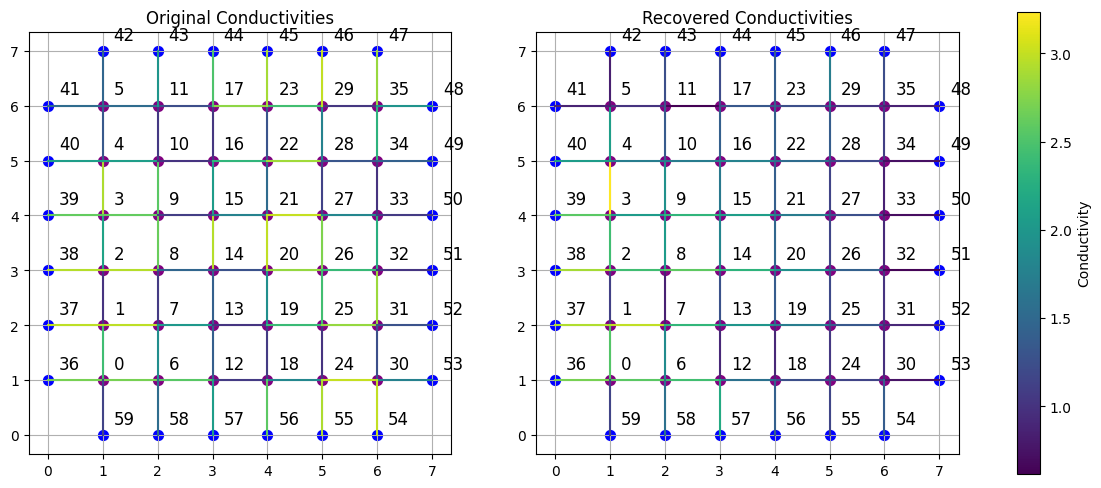



.........................................


.........................................


for n =  6
the batch size used for this training is  4
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.507582       
(0,6)      2.701984        2.631825       
(0,36)     2.701984        2.699256       
(0,59)     1.145108        1.147039       
(1,2)      1.011633        1.097424       
(1,7)      2.975587        3.029426       
(1,37)     2.975587        2.929736       
(2,3)      2.137771        2.488905       
(2,8)      2.939448        2.365598       
(2,38)     2.939448        2.895741       
(3,4)      2.909341        3.497407       
(3,9)      2.605040        2.461326       
(3,39)     2.605040        2.533643       
(4,5)      1.340625        2.001730       
(4,10)     2.078537        0.979756       
(4,40)     2.078537        1.913342       
(5,11)     1.527099        1.005349       
(5,41)   

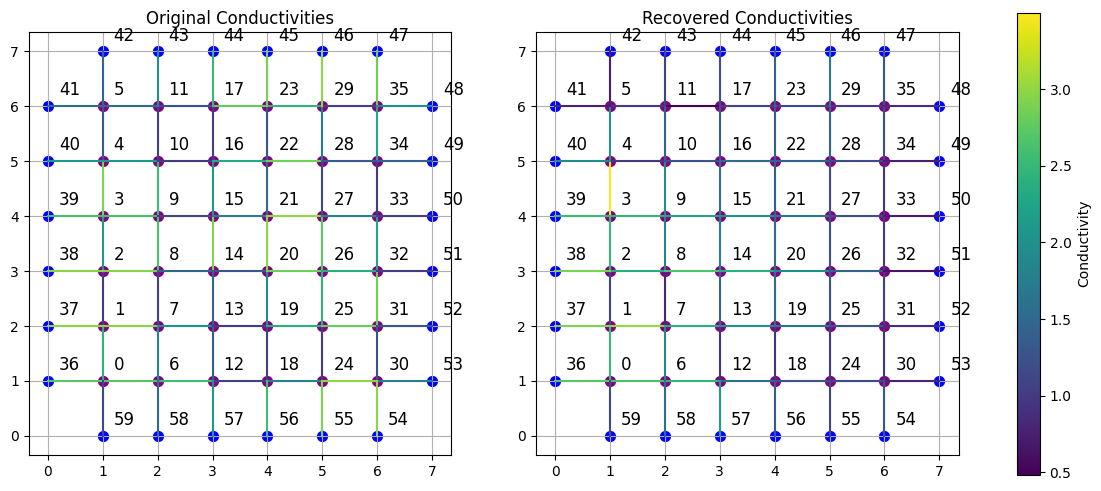



.........................................


.........................................


for n =  6
the batch size used for this training is  3
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.430969       
(0,6)      2.701984        2.839640       
(0,36)     2.701984        2.699516       
(0,59)     1.145108        1.146522       
(1,2)      1.011633        1.168174       
(1,7)      2.975587        3.124009       
(1,37)     2.975587        2.946419       
(2,3)      2.137771        3.988668       
(2,8)      2.939448        3.140550       
(2,38)     2.939448        2.736710       
(3,4)      2.909341        2.330885       
(3,9)      2.605040        0.942444       
(3,39)     2.605040        1.782426       
(4,5)      1.340625        1.517371       
(4,10)     2.078537        0.884232       
(4,40)     2.078537        1.430810       
(5,11)     1.527099        0.691405       
(5,41)   

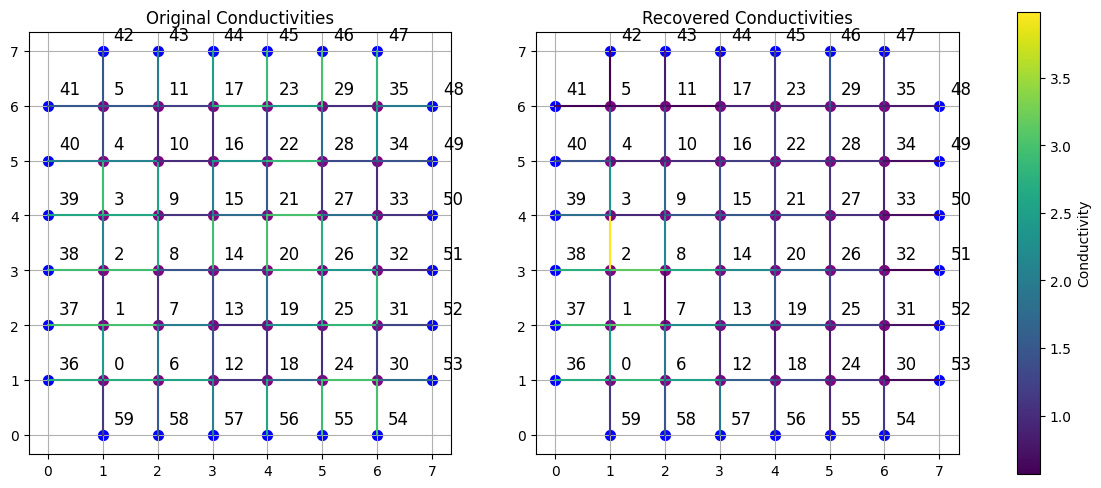



.........................................


.........................................


for n =  6
the batch size used for this training is  2
Conductivity Comparison Table:
Edge       True Gamma      Recovered Gamma
----------------------------------------
(0,1)      2.429163        2.628920       
(0,6)      2.701984        2.715513       
(0,36)     2.701984        2.701281       
(0,59)     1.145108        1.145569       
(1,2)      1.011633        2.926985       
(1,7)      2.975587        3.145905       
(1,37)     2.975587        2.823705       
(2,3)      2.137771        1.581144       
(2,8)      2.939448        1.108423       
(2,38)     2.939448        1.078829       
(3,4)      2.909341        1.161122       
(3,9)      2.605040        0.539096       
(3,39)     2.605040        0.761672       
(4,5)      1.340625        0.546137       
(4,10)     2.078537        0.396213       
(4,40)     2.078537        0.625611       
(5,11)     1.527099        0.385321       
(5,41)   

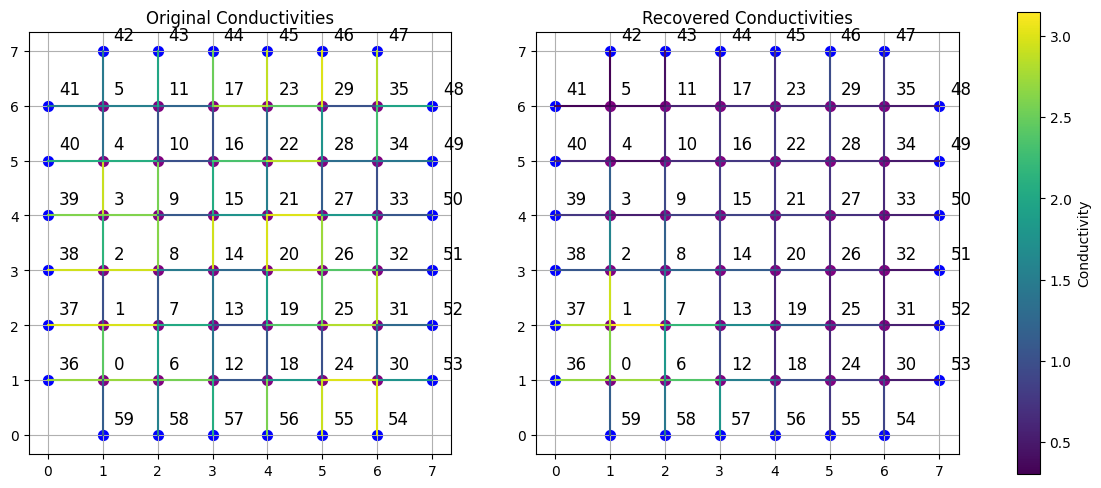



.........................................




In [16]:
run_demo_batch(6)